# DoS ML System

## Importing Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import joblib
from sklearn.preprocessing import LabelEncoder

from functions_ml import *
model_repo = ".\\DoS_system_2_models\\"
file_path = '.\Files\\DoS\\'

## Preprocessing data for binary classification (DoS (DDoS and DoS) or Benign)

In [3]:
train_sets, test_sets = get_train_and_test_files()
print(len(train_sets), len(test_sets))

X_columns = x_columns(read_csv_file(train_sets[0]))
y_column = 'label'

135 34


## Scaling

In [4]:
scaler = get_or_define_and_save_scaler(model_repo, train_sets, X_columns)

## Dictionnary for spliting data

In [3]:
dict_3_classes = {}
dict_3_classes['DDoS-RSTFINFlood'] = 'DoS'
dict_3_classes['DDoS-PSHACK_Flood'] = 'DoS'
dict_3_classes['DDoS-SYN_Flood'] = 'DoS'
dict_3_classes['DDoS-UDP_Flood'] = 'DoS'
dict_3_classes['DDoS-TCP_Flood'] = 'DoS'
dict_3_classes['DDoS-ICMP_Flood'] = 'DoS'
dict_3_classes['DDoS-SynonymousIP_Flood'] = 'DoS'
dict_3_classes['DDoS-ACK_Fragmentation'] = 'DoS'
dict_3_classes['DDoS-UDP_Fragmentation'] = 'DoS'
dict_3_classes['DDoS-ICMP_Fragmentation'] = 'DoS'
dict_3_classes['DDoS-SlowLoris'] = 'DoS'
dict_3_classes['DDoS-HTTP_Flood'] = 'DoS'
dict_3_classes['DoS-UDP_Flood'] = 'DoS'
dict_3_classes['DoS-SYN_Flood'] = 'DoS'
dict_3_classes['DoS-TCP_Flood'] = 'DoS'
dict_3_classes['DoS-HTTP_Flood'] = 'DoS'

dict_3_classes['BenignTraffic'] = 'Benign'

dict_3_classes['Mirai-greeth_flood'] = 'Other'
dict_3_classes['Mirai-greip_flood'] = 'Other'
dict_3_classes['Mirai-udpplain'] = 'Other'
dict_3_classes['Recon-PingSweep'] = 'Other'
dict_3_classes['Recon-OSScan'] = 'Other'
dict_3_classes['Recon-PortScan'] = 'Other'
dict_3_classes['VulnerabilityScan'] = 'Other'
dict_3_classes['Recon-HostDiscovery'] = 'Other'
dict_3_classes['DNS_Spoofing'] = 'Other'
dict_3_classes['MITM-ArpSpoofing'] = 'Other'
dict_3_classes['BrowserHijacking'] = 'Other'
dict_3_classes['Backdoor_Malware'] = 'Other'
dict_3_classes['XSS'] = 'Other'
dict_3_classes['Uploading_Attack'] = 'Other'
dict_3_classes['SqlInjection'] = 'Other'
dict_3_classes['CommandInjection'] = 'Other'
dict_3_classes['DictionaryBruteForce'] = 'Other'

## Refactoring data

In [4]:
train_sets.extend(test_sets)
refactor_dataframe(train_sets, dict_3_classes, file_path, y_column)

100%|██████████| 168/168 [15:07<00:00,  5.40s/it]


## Counting number of samples per class

95


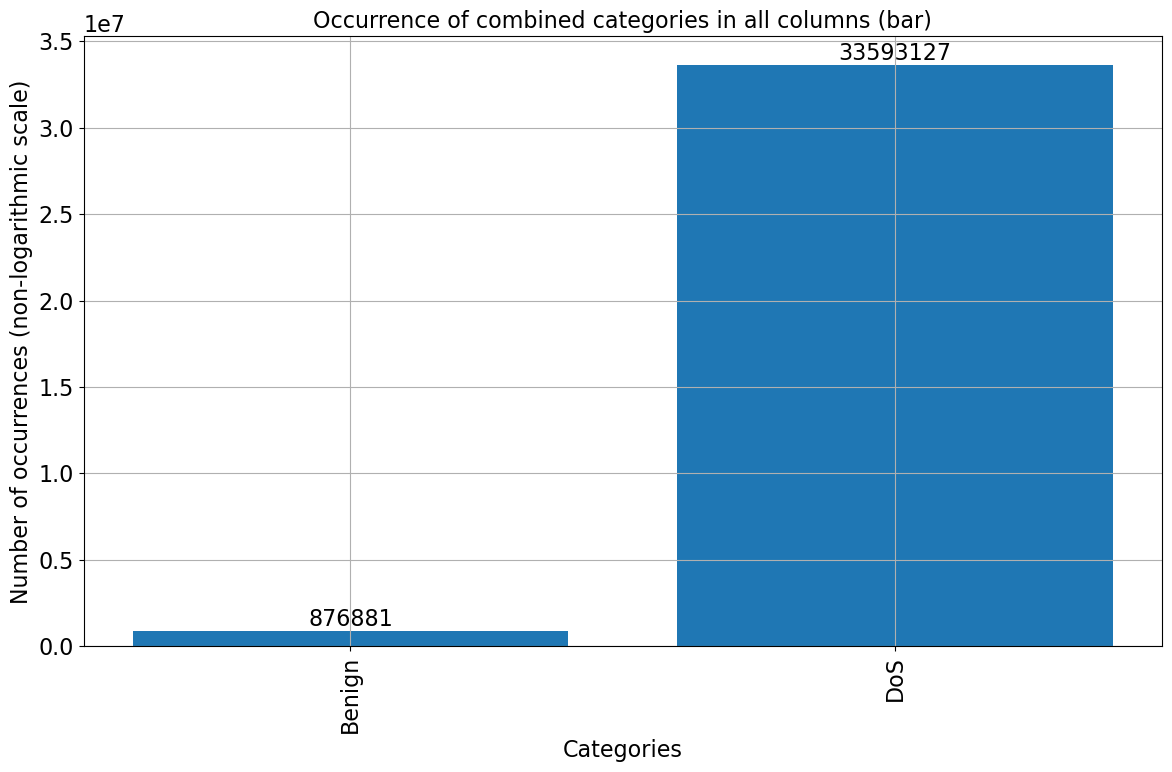

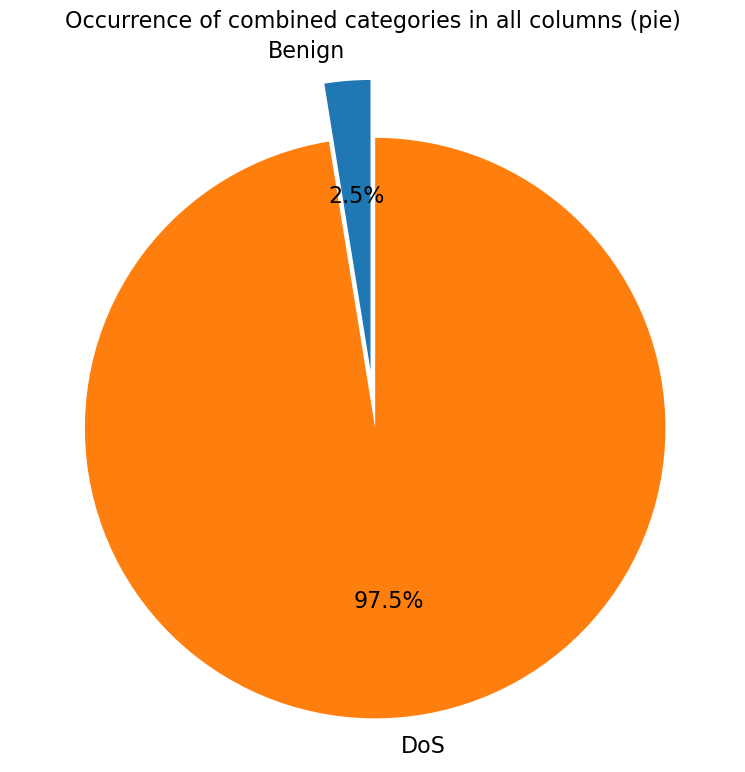

In [4]:
train_sets, test_sets = get_train_and_test_files(path_to_datasets=file_path)
print(len(train_sets) + len(test_sets))

plot_bar_chart(count_label(train_sets, file_path=file_path), 'Occurrence of combined categories in all columns (bar)', 'Categories', 'Number of occurrences', 12, 8, model_repo, log_scale=False)
plot_pie_chart(count_label(train_sets, file_path=file_path), 'Occurrence of combined categories in all columns (pie)', 12, 8, model_repo)

## Define variables

In [6]:
performance_path = 'performance.csv'
file_path = '.\Files\\DoS\\'
model_path_binary = '.\\DoS_system_2_models\\Binary\\'
local_path = '.\\DoS_system_2_models\\'
model_path_all_classes = '.\\DoS_system_2_models\\All_classes\\'
after_build_csv = 'after_build_set_scaled.csv'

# Get path data
build_sets, after_build_sets = get_train_and_test_files(path_to_datasets=file_path)
print(len(build_sets) + len(after_build_sets))

# Get build datasets
build_nb = round(len(build_sets) * 0.8)
train_sets = build_sets[:build_nb]
# train_sets = train_sets[: round(len(train_sets) * 0.5)]
test_sets = build_sets[build_nb:]
# test_sets = test_sets[: round(len(test_sets) * 0.5)]

# Define different columns
X_columns = x_columns(read_csv_file(train_sets[0], path_to_datasets=file_path))
X_columns = X_columns[:-2]
print(len(X_columns))
y_column = 'label'
z_column = 'Binary'

95
46


# First model (DoS (DDoS and DoS) or Benign)

## Buiding models

In [9]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
    {
        "Name": "RF",
        "Model": RandomForestClassifier(random_state = 42)
    },
    {
        "Name": "ET",
        "Model": ExtraTreesClassifier(random_state = 42)
    },
    {
        "Name": "XGB",
        "Model": XGBClassifier(random_state = 42)
    },
    {
        "Name": "Cat",
        "Model": CatBoostClassifier(random_state = 42, verbose = 0)
    },
    {
        "Name": "LIGHT",
        "Model": LGBMClassifier(random_state = 42)
    },
    {
        "Name": "GBoost",
        "Model": GradientBoostingClassifier(random_state = 42)
    },
    {
        "Name": "Adaboost",
        "Model": AdaBoostClassifier(random_state = 42)
    },
    {
        "Name": "MLP",
        "Model": MLPClassifier(hidden_layer_sizes = (100,20), max_iter = 300, activation = 'relu', solver = 'adam', random_state = 42)
    },
]

100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


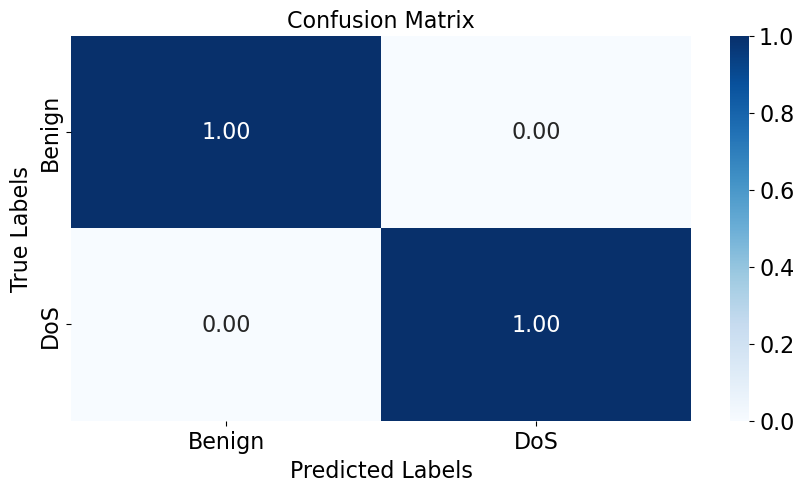

100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


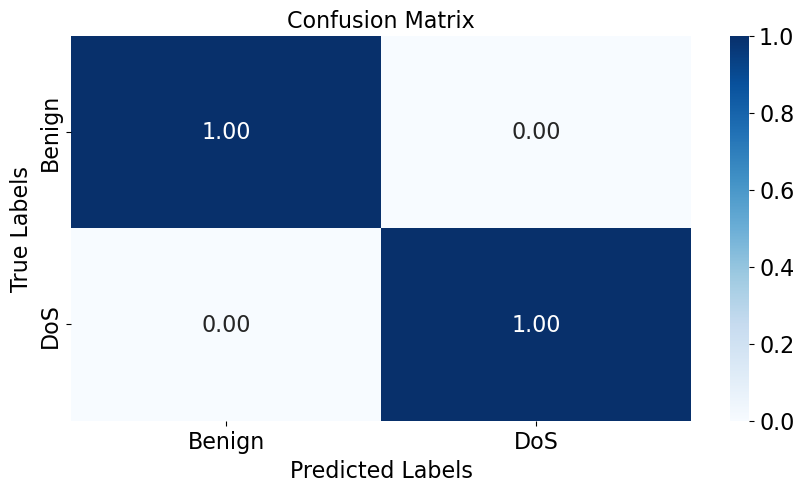

100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


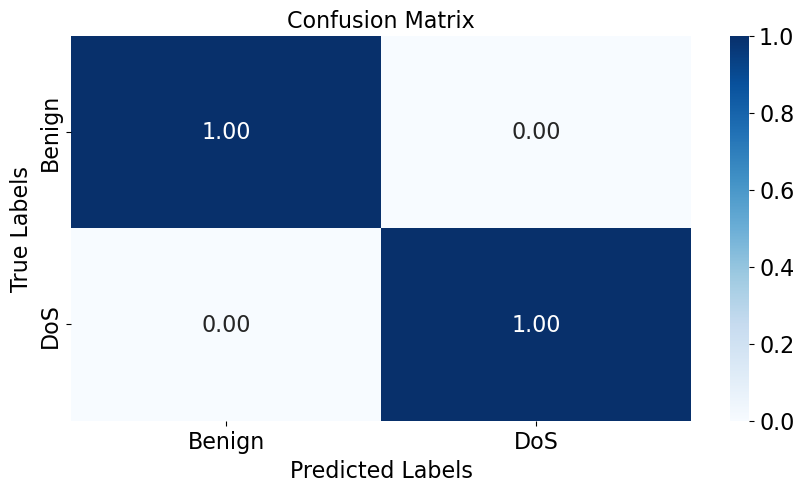

100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


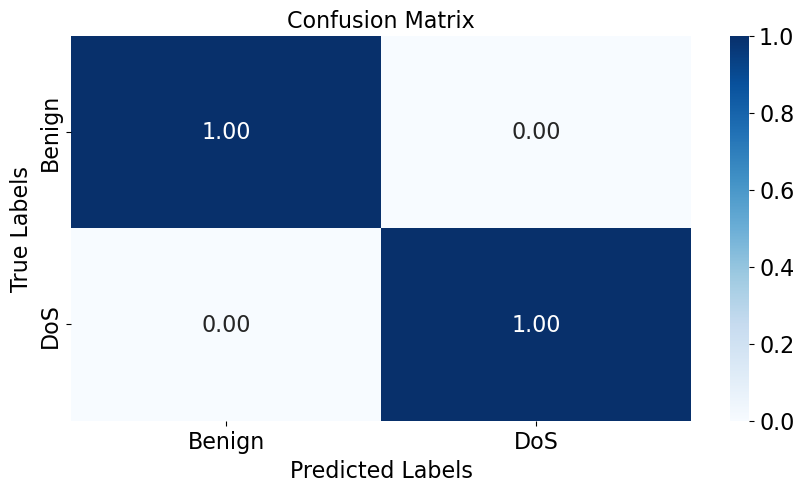

100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


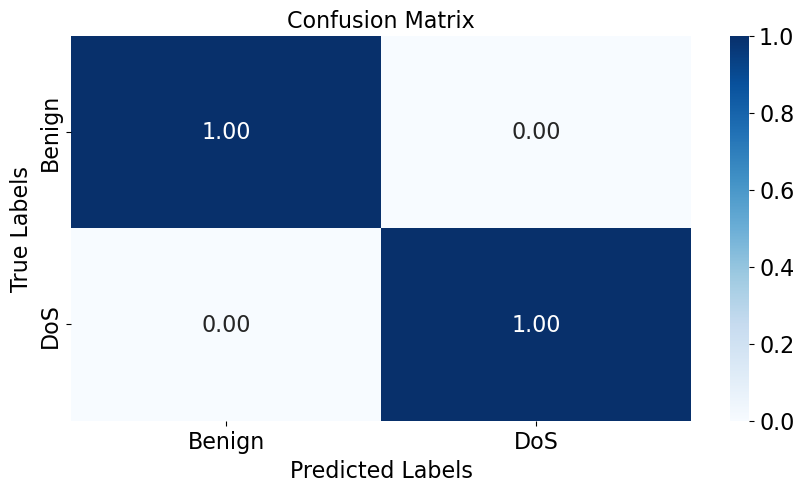

 56%|█████▌    | 5/9 [1:08:27<1:09:59, 1049.76s/it]  File "c:\Users\mlcra\AppData\Local\Programs\Orange\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Number of positive: 416617, number of negative: 10798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 427415, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974736 -> initscore=3.652806
[LightGBM] [Info] Start training from score 3.652806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 411949, number of negative: 10800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1603
[LightGBM] [Info] Number of data points in the train set: 422749, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974453 -> initscore=3.641353
[LightGBM] [Info] Start training from score 3.641353


[LightGBM] [Info] Number of positive: 456623, number of negative: 11684
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1656
[LightGBM] [Info] Number of data points in the train set: 468307, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.975051 -> initscore=3.665638
[LightGBM] [Info] Start training from score 3.665638


[LightGBM] [Info] Number of positive: 415250, number of negative: 10701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1601
[LightGBM] [Info] Number of data points in the train set: 425951, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974877 -> initscore=3.658544
[LightGBM] [Info] Start training from score 3.658544


[LightGBM] [Info] Number of positive: 463106, number of negative: 12340
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1658
[LightGBM] [Info] Number of data points in the train set: 475446, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974045 -> initscore=3.625110
[LightGBM] [Info] Start training from score 3.625110


[LightGBM] [Info] Number of positive: 606792, number of negative: 15668
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1647
[LightGBM] [Info] Number of data points in the train set: 622460, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974829 -> initscore=3.656566
[LightGBM] [Info] Start training from score 3.656566


[LightGBM] [Info] Number of positive: 412104, number of negative: 10817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1647
[LightGBM] [Info] Number of data points in the train set: 422921, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974423 -> initscore=3.640157
[LightGBM] [Info] Start training from score 3.640157


[LightGBM] [Info] Number of positive: 453002, number of negative: 11908
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1603
[LightGBM] [Info] Number of data points in the train set: 464910, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974386 -> initscore=3.638686
[LightGBM] [Info] Start training from score 3.638686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 420755, number of negative: 11082
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1598
[LightGBM] [Info] Number of data points in the train set: 431837, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974338 -> initscore=3.636729
[LightGBM] [Info] Start training from score 3.636729


[LightGBM] [Info] Number of positive: 608772, number of negative: 15952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1600
[LightGBM] [Info] Number of data points in the train set: 624724, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974466 -> initscore=3.641860
[LightGBM] [Info] Start training from score 3.641860


[LightGBM] [Info] Number of positive: 436894, number of negative: 11390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1655
[LightGBM] [Info] Number of data points in the train set: 448284, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974592 -> initscore=3.646955
[LightGBM] [Info] Start training from score 3.646955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 395716, number of negative: 10406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1645
[LightGBM] [Info] Number of data points in the train set: 406122, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974377 -> initscore=3.638314
[LightGBM] [Info] Start training from score 3.638314


[LightGBM] [Info] Number of positive: 406863, number of negative: 10745
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1658
[LightGBM] [Info] Number of data points in the train set: 417608, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974270 -> initscore=3.634036
[LightGBM] [Info] Start training from score 3.634036


[LightGBM] [Info] Number of positive: 421386, number of negative: 11173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1611
[LightGBM] [Info] Number of data points in the train set: 432559, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974170 -> initscore=3.630049
[LightGBM] [Info] Start training from score 3.630049


[LightGBM] [Info] Number of positive: 394364, number of negative: 10227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1598
[LightGBM] [Info] Number of data points in the train set: 404591, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974723 -> initscore=3.652243
[LightGBM] [Info] Start training from score 3.652243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 609326, number of negative: 15731
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1662
[LightGBM] [Info] Number of data points in the train set: 625057, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974833 -> initscore=3.656720
[LightGBM] [Info] Start training from score 3.656720


[LightGBM] [Info] Number of positive: 426593, number of negative: 11314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1595
[LightGBM] [Info] Number of data points in the train set: 437907, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974163 -> initscore=3.629790
[LightGBM] [Info] Start training from score 3.629790


[LightGBM] [Info] Number of positive: 431919, number of negative: 11370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 443289, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974351 -> initscore=3.637260
[LightGBM] [Info] Start training from score 3.637260


[LightGBM] [Info] Number of positive: 428009, number of negative: 11158
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1661
[LightGBM] [Info] Number of data points in the train set: 439167, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974593 -> initscore=3.646987
[LightGBM] [Info] Start training from score 3.646987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 422654, number of negative: 10879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1653
[LightGBM] [Info] Number of data points in the train set: 433533, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974906 -> initscore=3.659720
[LightGBM] [Info] Start training from score 3.659720


[LightGBM] [Info] Number of positive: 437092, number of negative: 11308
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1607
[LightGBM] [Info] Number of data points in the train set: 448400, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974781 -> initscore=3.654633
[LightGBM] [Info] Start training from score 3.654633


[LightGBM] [Info] Number of positive: 401242, number of negative: 10457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1598
[LightGBM] [Info] Number of data points in the train set: 411699, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974600 -> initscore=3.647293
[LightGBM] [Info] Start training from score 3.647293


[LightGBM] [Info] Number of positive: 431840, number of negative: 11105
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1600
[LightGBM] [Info] Number of data points in the train set: 442945, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974929 -> initscore=3.660660
[LightGBM] [Info] Start training from score 3.660660


[LightGBM] [Info] Number of positive: 412724, number of negative: 10692
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1596
[LightGBM] [Info] Number of data points in the train set: 423416, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974748 -> initscore=3.653283
[LightGBM] [Info] Start training from score 3.653283


[LightGBM] [Info] Number of positive: 416144, number of negative: 10864
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 427008, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974558 -> initscore=3.645577
[LightGBM] [Info] Start training from score 3.645577


[LightGBM] [Info] Number of positive: 387033, number of negative: 10060
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1596
[LightGBM] [Info] Number of data points in the train set: 397093, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974666 -> initscore=3.649943
[LightGBM] [Info] Start training from score 3.649943


[LightGBM] [Info] Number of positive: 434518, number of negative: 11364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1604
[LightGBM] [Info] Number of data points in the train set: 445882, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974513 -> initscore=3.643787
[LightGBM] [Info] Start training from score 3.643787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 444658, number of negative: 11757
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1602
[LightGBM] [Info] Number of data points in the train set: 456415, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974241 -> initscore=3.632857
[LightGBM] [Info] Start training from score 3.632857


[LightGBM] [Info] Number of positive: 397179, number of negative: 10509
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1643
[LightGBM] [Info] Number of data points in the train set: 407688, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974223 -> initscore=3.632155
[LightGBM] [Info] Start training from score 3.632155


[LightGBM] [Info] Number of positive: 451287, number of negative: 11793
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1606
[LightGBM] [Info] Number of data points in the train set: 463080, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974534 -> initscore=3.644597
[LightGBM] [Info] Start training from score 3.644597


[LightGBM] [Info] Number of positive: 415149, number of negative: 10932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1598
[LightGBM] [Info] Number of data points in the train set: 426081, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974343 -> initscore=3.636943
[LightGBM] [Info] Start training from score 3.636943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 443577, number of negative: 11499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1596
[LightGBM] [Info] Number of data points in the train set: 455076, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974732 -> initscore=3.652611
[LightGBM] [Info] Start training from score 3.652611


[LightGBM] [Info] Number of positive: 423601, number of negative: 10921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1609
[LightGBM] [Info] Number of data points in the train set: 434522, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974867 -> initscore=3.658104
[LightGBM] [Info] Start training from score 3.658104


[LightGBM] [Info] Number of positive: 485345, number of negative: 12727
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 498072, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974447 -> initscore=3.641134
[LightGBM] [Info] Start training from score 3.641134


[LightGBM] [Info] Number of positive: 435247, number of negative: 11267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1592
[LightGBM] [Info] Number of data points in the train set: 446514, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974767 -> initscore=3.654036
[LightGBM] [Info] Start training from score 3.654036


[LightGBM] [Info] Number of positive: 427188, number of negative: 11338
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1597
[LightGBM] [Info] Number of data points in the train set: 438526, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974145 -> initscore=3.629064
[LightGBM] [Info] Start training from score 3.629064


[LightGBM] [Info] Number of positive: 400307, number of negative: 10566
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 410873, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974284 -> initscore=3.634590
[LightGBM] [Info] Start training from score 3.634590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 402869, number of negative: 10563
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1609
[LightGBM] [Info] Number of data points in the train set: 413432, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974450 -> initscore=3.641254
[LightGBM] [Info] Start training from score 3.641254


[LightGBM] [Info] Number of positive: 392641, number of negative: 10255
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1657
[LightGBM] [Info] Number of data points in the train set: 402896, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974547 -> initscore=3.645130
[LightGBM] [Info] Start training from score 3.645130


[LightGBM] [Info] Number of positive: 391658, number of negative: 10315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1645
[LightGBM] [Info] Number of data points in the train set: 401973, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974339 -> initscore=3.636790
[LightGBM] [Info] Start training from score 3.636790


[LightGBM] [Info] Number of positive: 406621, number of negative: 10608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1654
[LightGBM] [Info] Number of data points in the train set: 417229, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974575 -> initscore=3.646273
[LightGBM] [Info] Start training from score 3.646273


[LightGBM] [Info] Number of positive: 419989, number of negative: 11097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 431086, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974258 -> initscore=3.633554
[LightGBM] [Info] Start training from score 3.633554


[LightGBM] [Info] Number of positive: 413552, number of negative: 10816
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1661
[LightGBM] [Info] Number of data points in the train set: 424368, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974513 -> initscore=3.643757
[LightGBM] [Info] Start training from score 3.643757


[LightGBM] [Info] Number of positive: 421776, number of negative: 10832
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1594
[LightGBM] [Info] Number of data points in the train set: 432608, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974961 -> initscore=3.661970
[LightGBM] [Info] Start training from score 3.661970


[LightGBM] [Info] Number of positive: 431922, number of negative: 10992
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1657
[LightGBM] [Info] Number of data points in the train set: 442914, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.975183 -> initscore=3.671077
[LightGBM] [Info] Start training from score 3.671077


[LightGBM] [Info] Number of positive: 422683, number of negative: 11161
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 433844, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974274 -> initscore=3.634197
[LightGBM] [Info] Start training from score 3.634197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 426466, number of negative: 11213
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1663
[LightGBM] [Info] Number of data points in the train set: 437679, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974381 -> initscore=3.638459
[LightGBM] [Info] Start training from score 3.638459


[LightGBM] [Info] Number of positive: 451234, number of negative: 11873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1652
[LightGBM] [Info] Number of data points in the train set: 463107, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974362 -> initscore=3.637719
[LightGBM] [Info] Start training from score 3.637719


[LightGBM] [Info] Number of positive: 419828, number of negative: 10920
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data points in the train set: 430748, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974649 -> initscore=3.649249
[LightGBM] [Info] Start training from score 3.649249


[LightGBM] [Info] Number of positive: 386177, number of negative: 10106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 396283, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974498 -> initscore=3.643167
[LightGBM] [Info] Start training from score 3.643167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 400573, number of negative: 10568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1596
[LightGBM] [Info] Number of data points in the train set: 411141, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974296 -> initscore=3.635065
[LightGBM] [Info] Start training from score 3.635065


[LightGBM] [Info] Number of positive: 450620, number of negative: 11641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1599
[LightGBM] [Info] Number of data points in the train set: 462261, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974817 -> initscore=3.656091
[LightGBM] [Info] Start training from score 3.656091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 402940, number of negative: 10420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1612
[LightGBM] [Info] Number of data points in the train set: 413360, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974792 -> initscore=3.655061
[LightGBM] [Info] Start training from score 3.655061


[LightGBM] [Info] Number of positive: 421485, number of negative: 11152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 432637, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974223 -> initscore=3.632165
[LightGBM] [Info] Start training from score 3.632165


[LightGBM] [Info] Number of positive: 419575, number of negative: 10996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1600
[LightGBM] [Info] Number of data points in the train set: 430571, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974462 -> initscore=3.641711
[LightGBM] [Info] Start training from score 3.641711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 429321, number of negative: 11003
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1663
[LightGBM] [Info] Number of data points in the train set: 440324, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.975012 -> initscore=3.664037
[LightGBM] [Info] Start training from score 3.664037


[LightGBM] [Info] Number of positive: 434789, number of negative: 11524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1598
[LightGBM] [Info] Number of data points in the train set: 446313, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974180 -> initscore=3.630429
[LightGBM] [Info] Start training from score 3.630429


[LightGBM] [Info] Number of positive: 429961, number of negative: 11150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1614
[LightGBM] [Info] Number of data points in the train set: 441111, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974723 -> initscore=3.652255
[LightGBM] [Info] Start training from score 3.652255


[LightGBM] [Info] Number of positive: 410470, number of negative: 10708
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1601
[LightGBM] [Info] Number of data points in the train set: 421178, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974576 -> initscore=3.646312
[LightGBM] [Info] Start training from score 3.646312


[LightGBM] [Info] Number of positive: 450222, number of negative: 11639
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1604
[LightGBM] [Info] Number of data points in the train set: 461861, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974800 -> initscore=3.655379
[LightGBM] [Info] Start training from score 3.655379


[LightGBM] [Info] Number of positive: 471449, number of negative: 12122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 483571, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.974932 -> initscore=3.660789
[LightGBM] [Info] Start training from score 3.660789


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


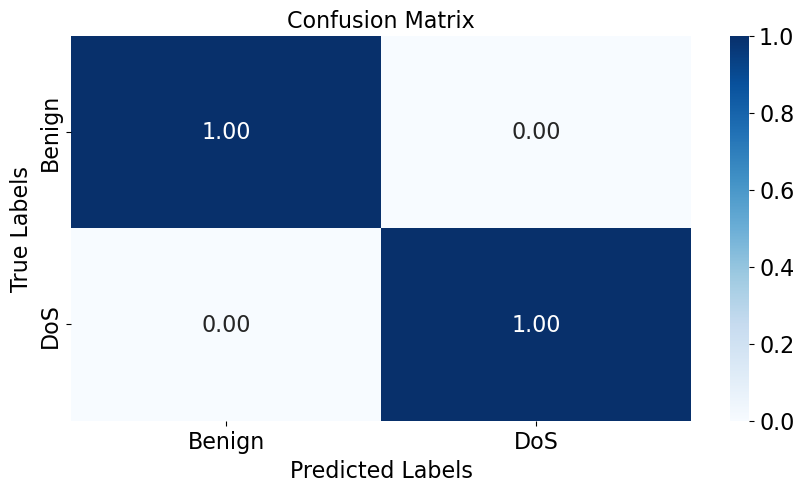

100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


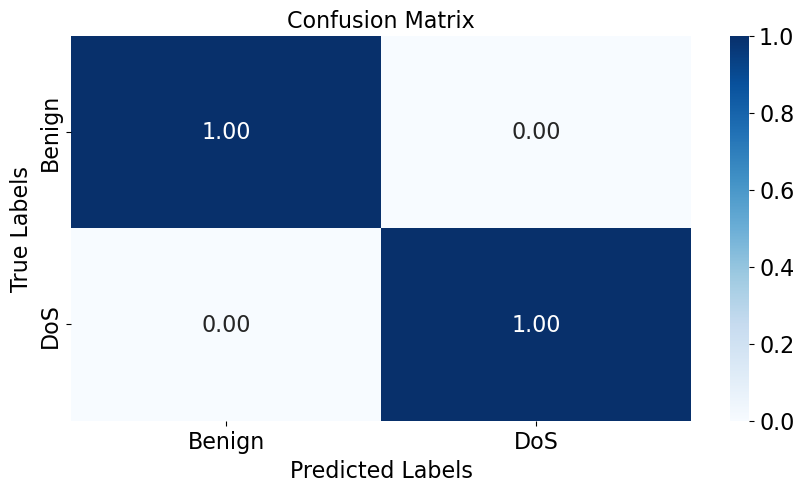

100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


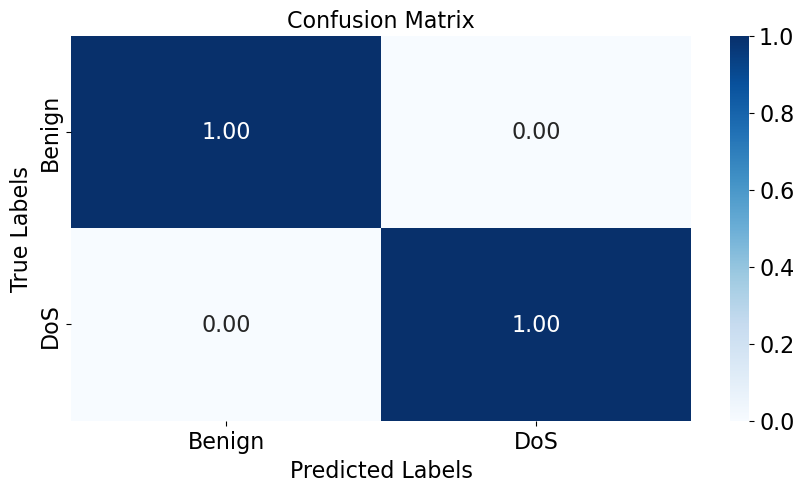

100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


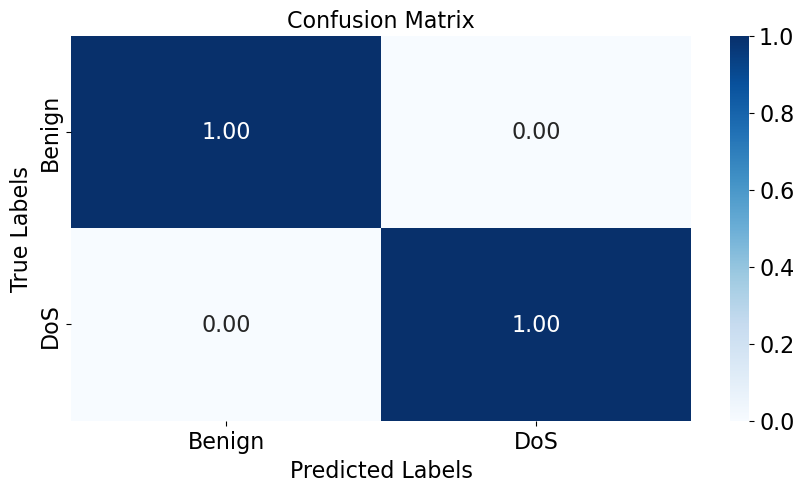

100%|██████████| 9/9 [2:40:17<00:00, 1068.63s/it]


['.\\DoS_system_2_models\\Binary\\encoder.joblib']

In [10]:
# Import or define encoder and performance dataframe
encoder = get_or_define_encoder(model_path_binary)
performance = get_or_define_performance_df(model_path_binary, performance_path)

# Load selected X columns
selected_X = pd.read_csv(model_path_binary+'selected_X_columns.csv').values

# Map selected X columns
selected_X = list(map(lambda x: x[0], selected_X))

# Buidling models
plotConfusionMatrix = True
figsizeConfusionMatrix = (10, 5)
saveConfusionMatrix = False
for model in tqdm(simpleModelsDef):
    # Build model
    performance, encoder = build_model_multifiltered(model['Model'], 'SF_'+model['Name'], train_sets, test_sets, file_path, performance, model_path_binary+'SF_', X_columns=selected_X, y_column=z_column, encoder=encoder, scaler=scaler, \
                                                     confusionMatrix=plotConfusionMatrix, saving=saveConfusionMatrix, pathToSave=model_path_binary+'SF_'+model['Name'], figsize=figsizeConfusionMatrix)

    # Save performance
    performance.to_csv(model_path_binary + performance_path, index=False)

# Save the encoder to a file
joblib.dump(encoder, model_path_binary+'encoder.joblib')

#### Features importance

In [7]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": joblib.load(model_path_binary+'model_DT.joblib')
    },
    {
        "Name": "RF",
        "Model": joblib.load(model_path_binary+'model_RF.joblib')
    },
    {
        "Name": "XGB",
        "Model": joblib.load(model_path_binary+'model_XGB.joblib')
    },
    {
        "Name": "Cat",
        "Model": joblib.load(model_path_binary+'model_Cat.joblib')
    },
    {
        "Name": "LIGHT",
        "Model": joblib.load(model_path_binary+'model_LIGHT.joblib')
    },
    {
        "Name": "GBoost",
        "Model": joblib.load(model_path_binary+'model_GBoost.joblib')
    },
    {
        "Name": "Adaboost",
        "Model": joblib.load(model_path_binary+'model_Adaboost.joblib')
    },
]

100%|██████████| 7/7 [00:00<00:00, 303.91it/s]

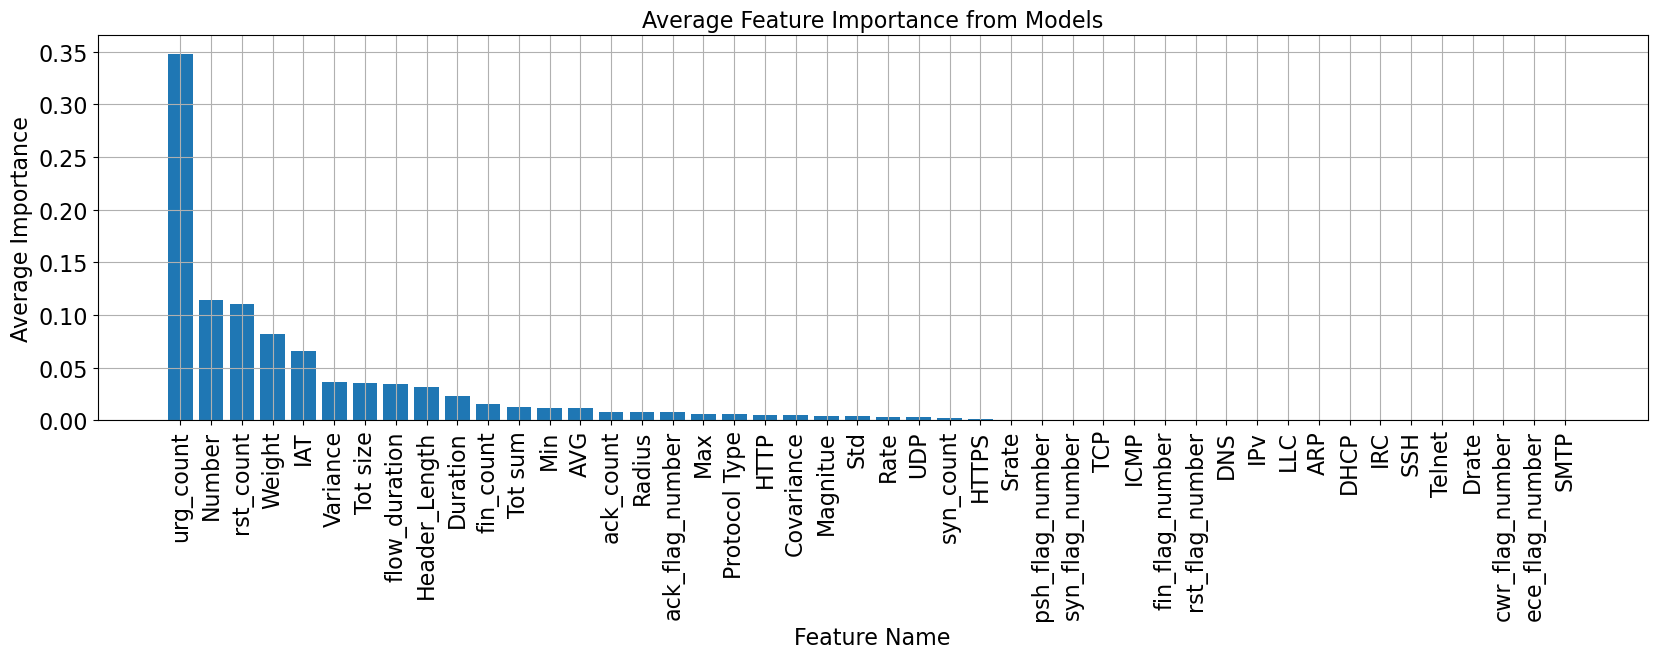

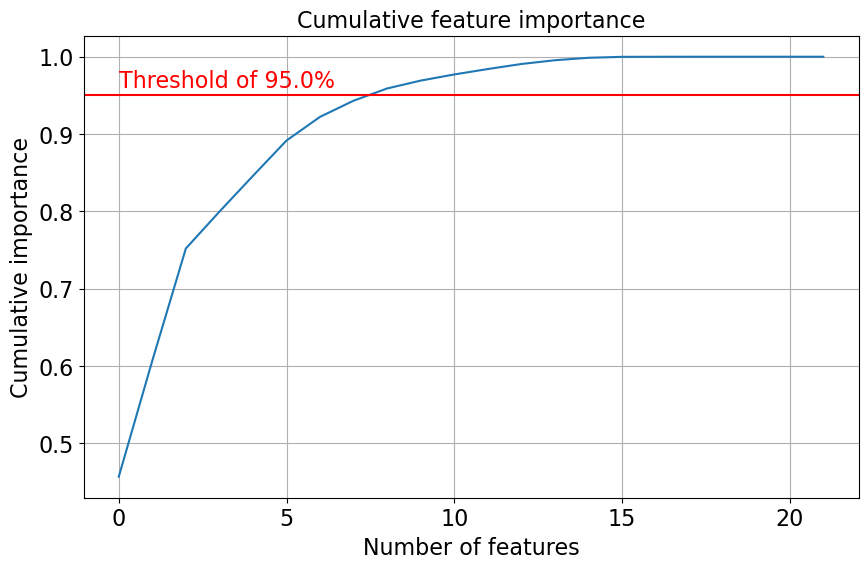

['urg_count', 'Number', 'rst_count', 'Variance', 'Tot size', 'flow_duration', 'Duration', 'fin_count']


100%|██████████| 61/61 [01:12<00:00,  1.18s/it]


In [8]:
# Get feature importance
average_importance_df = calculate_and_plot_feature_importance(simpleModelsDef, X_columns, model_path_binary, all_features=True)
average_importance_df.to_csv(model_path_binary+'feature_importance.csv', index=False)
average_importance_df.to_csv('.\\resultats\\DoS_2_models\\Binary\\feature_importance.csv', index=False)

# Load feature importance dataframe
average_importance_df = pd.read_csv(model_path_binary+'feature_importance.csv')
# print(average_importance_df.head(average_importance_df.size))

# Remove features with correlation > 0.80
threshold = 0.80
features_with_threshold_corr = remove_features_with_correlation_and_feature_importance(read_csv_file(train_sets[0], file_path)[X_columns], average_importance_df, threshold=threshold)
# print(features_with_threshold_corr.head(features_with_threshold_corr.size))

# Select features with cumulative importance > 0.95 and correlation < 0.80
selected_X = select_features_by_importance(features_with_threshold_corr['Feature'].values, features_with_threshold_corr['Average Importance'].values, model_path_binary, threshold_percentage=0.95)
pd.DataFrame(selected_X).to_csv(model_path_binary+'selected_X_columns.csv', index=False)
print(selected_X)

# Define and fit scaler
scaler = MinMaxScaler()
for train_set in tqdm(train_sets):
    scaler.fit(read_csv_file(train_set, file_path)[selected_X])

##### Some plots

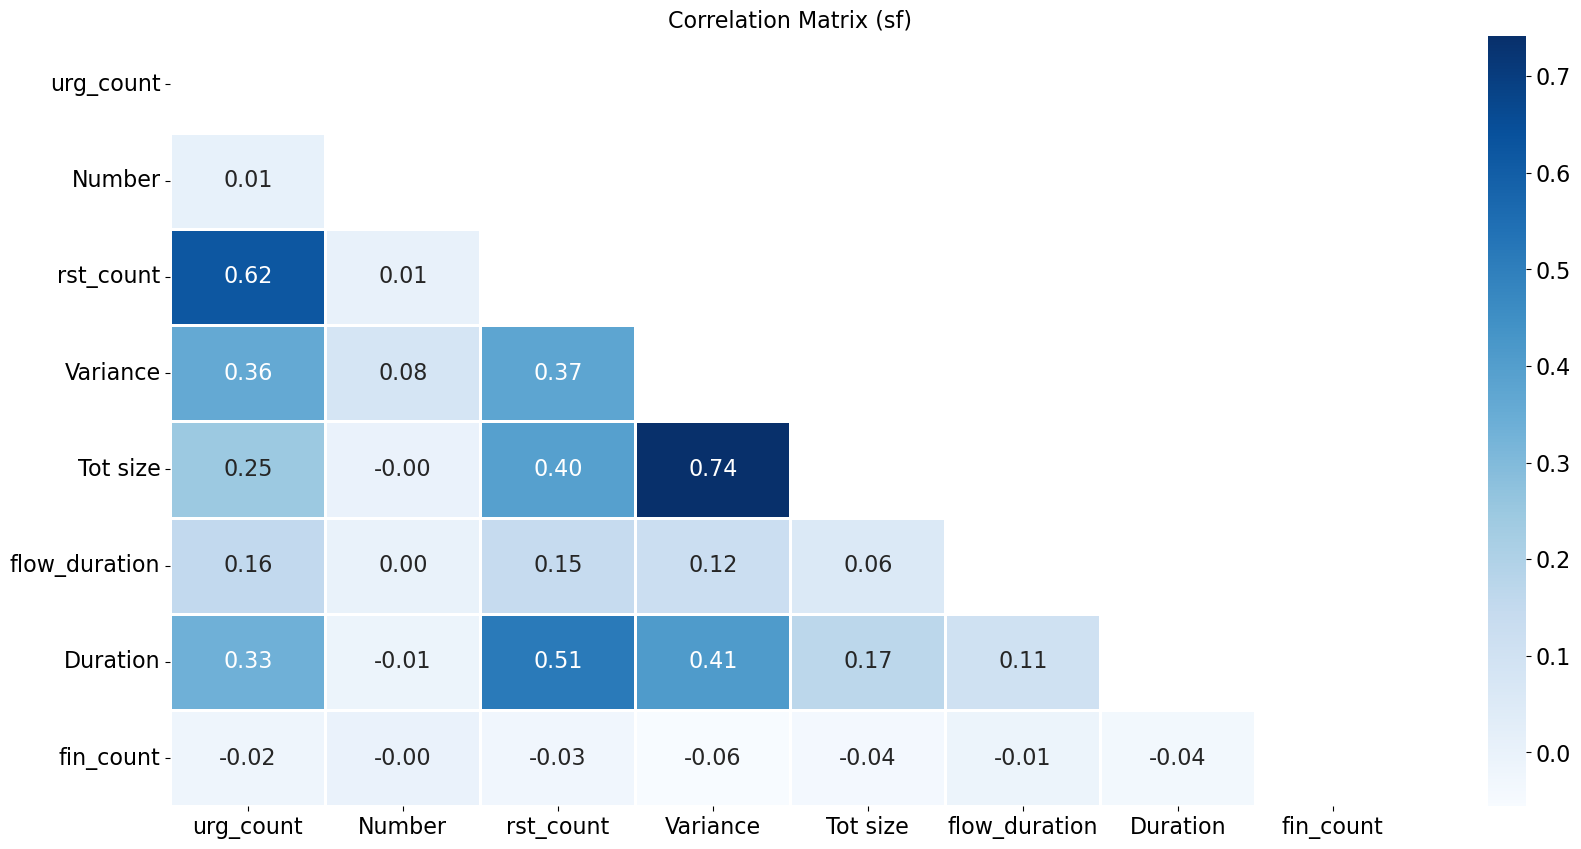

<Figure size 2000x1000 with 0 Axes>

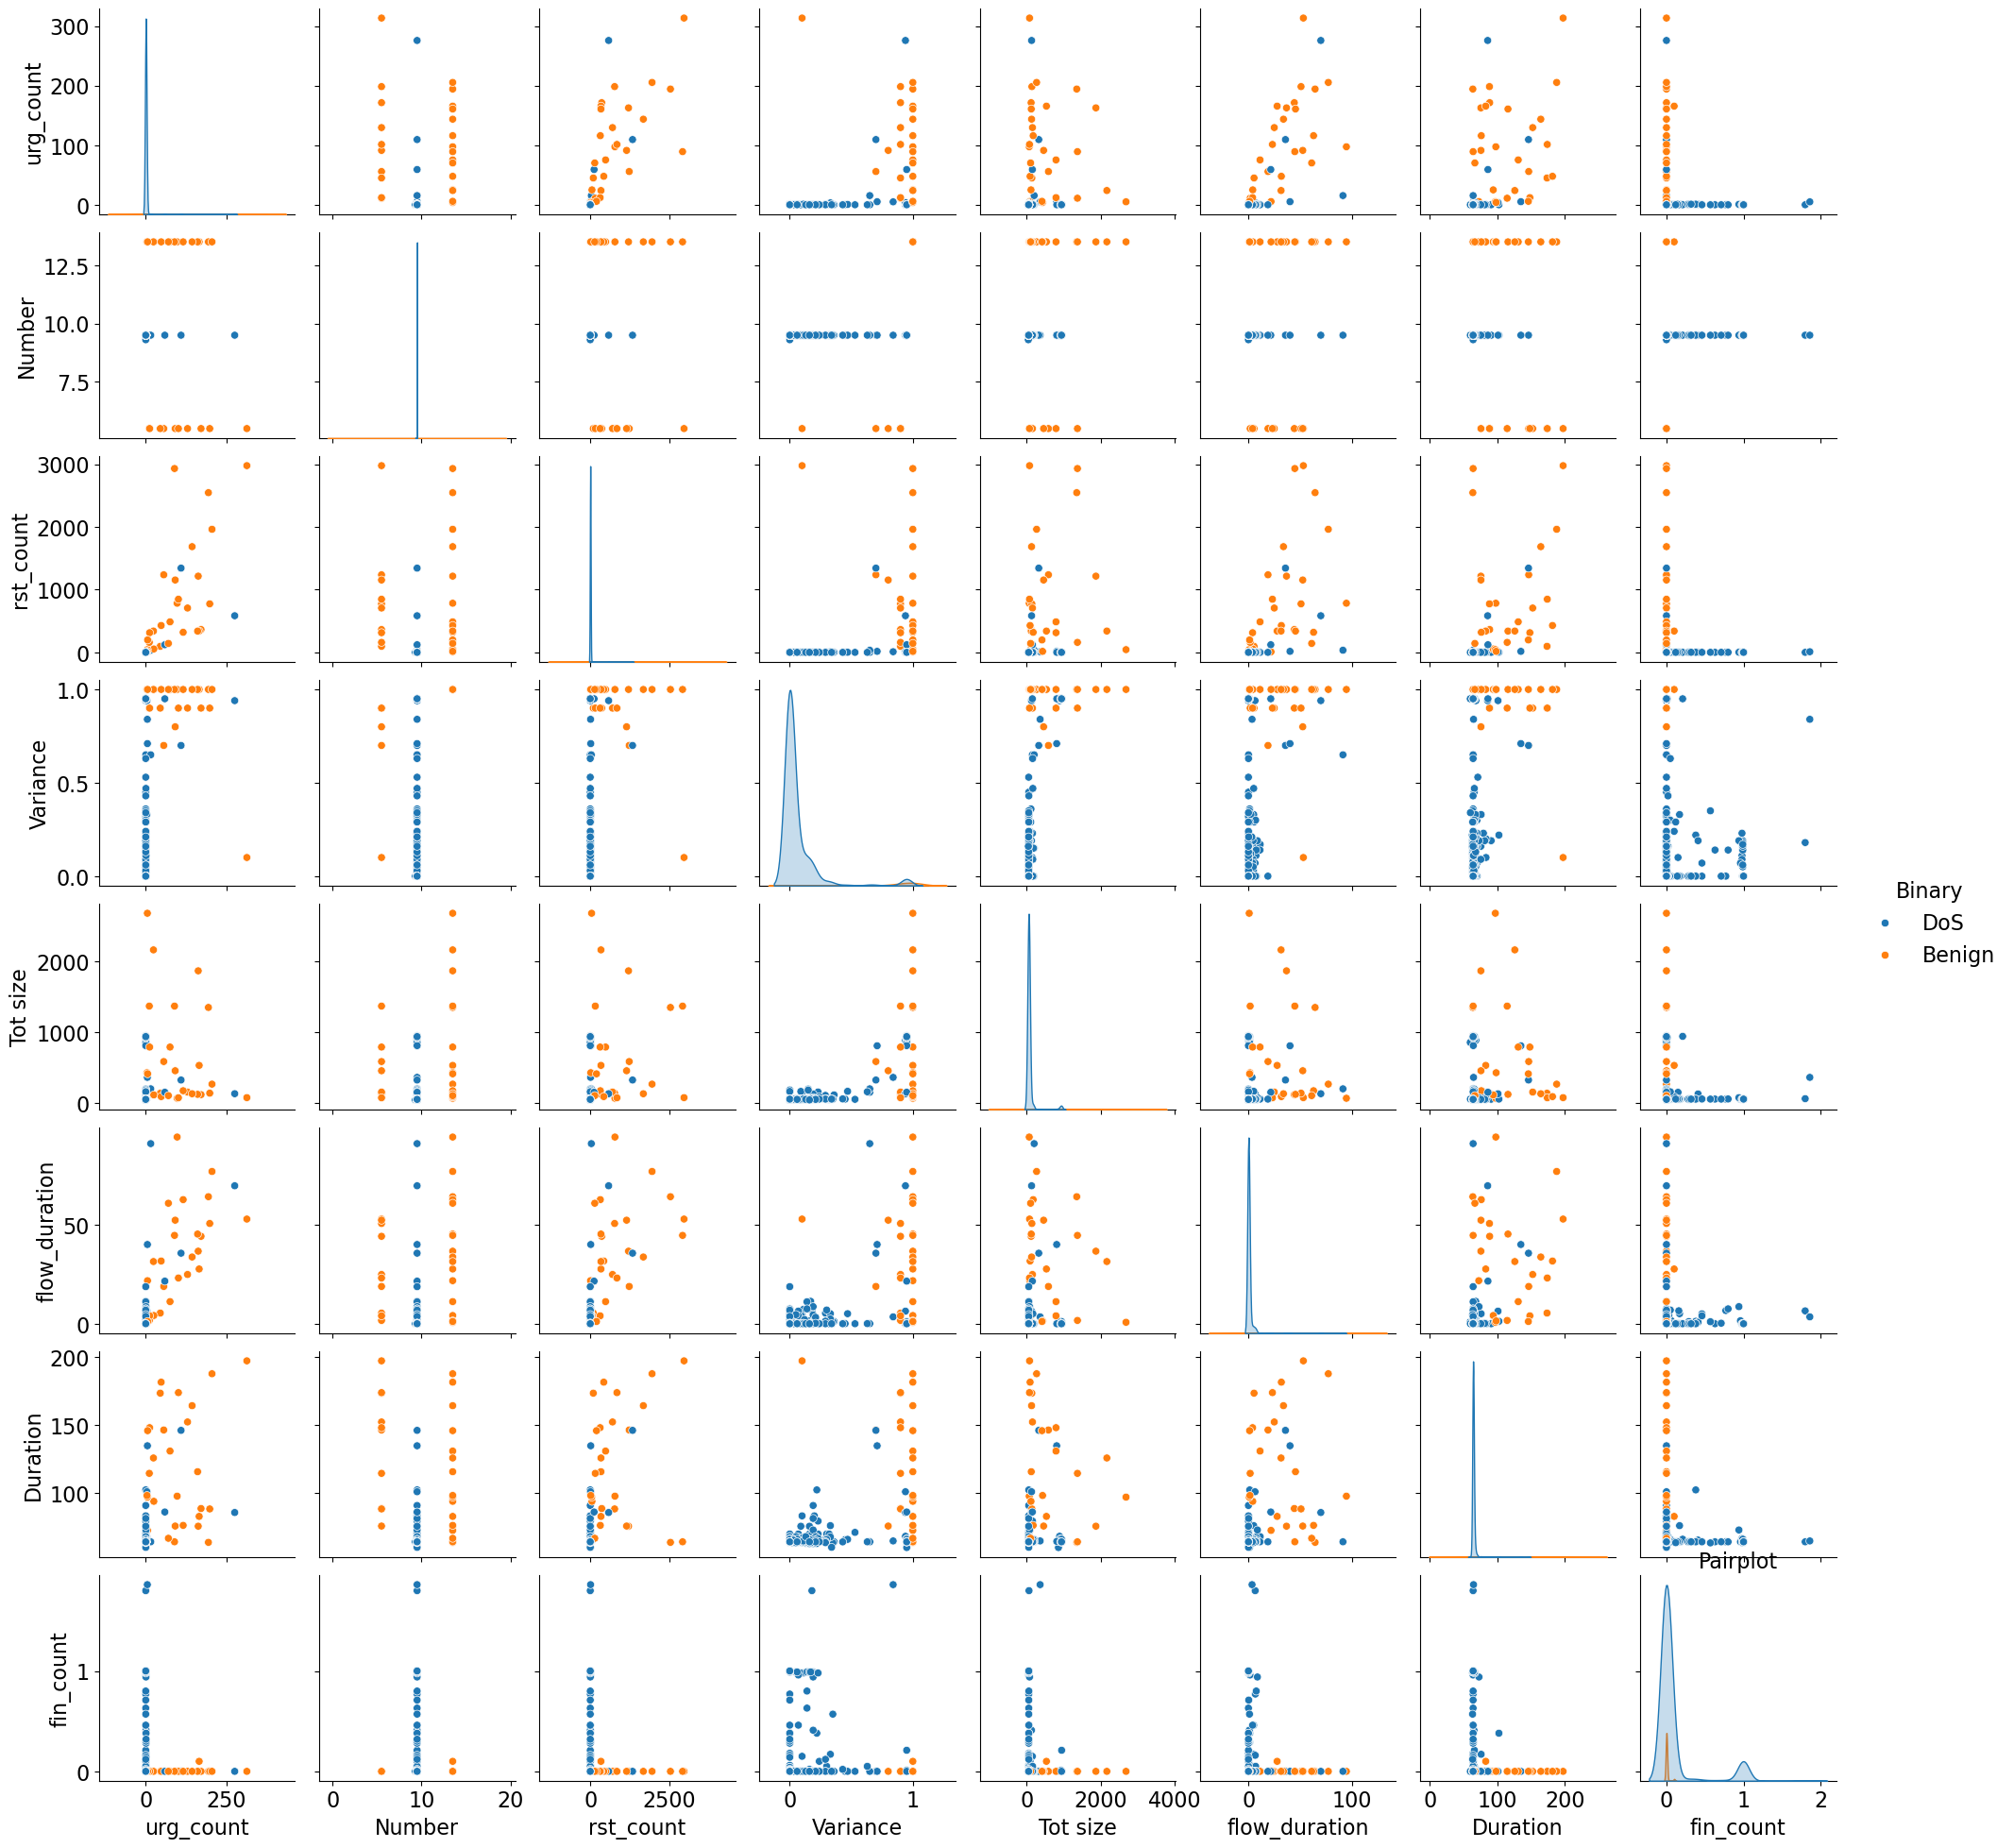

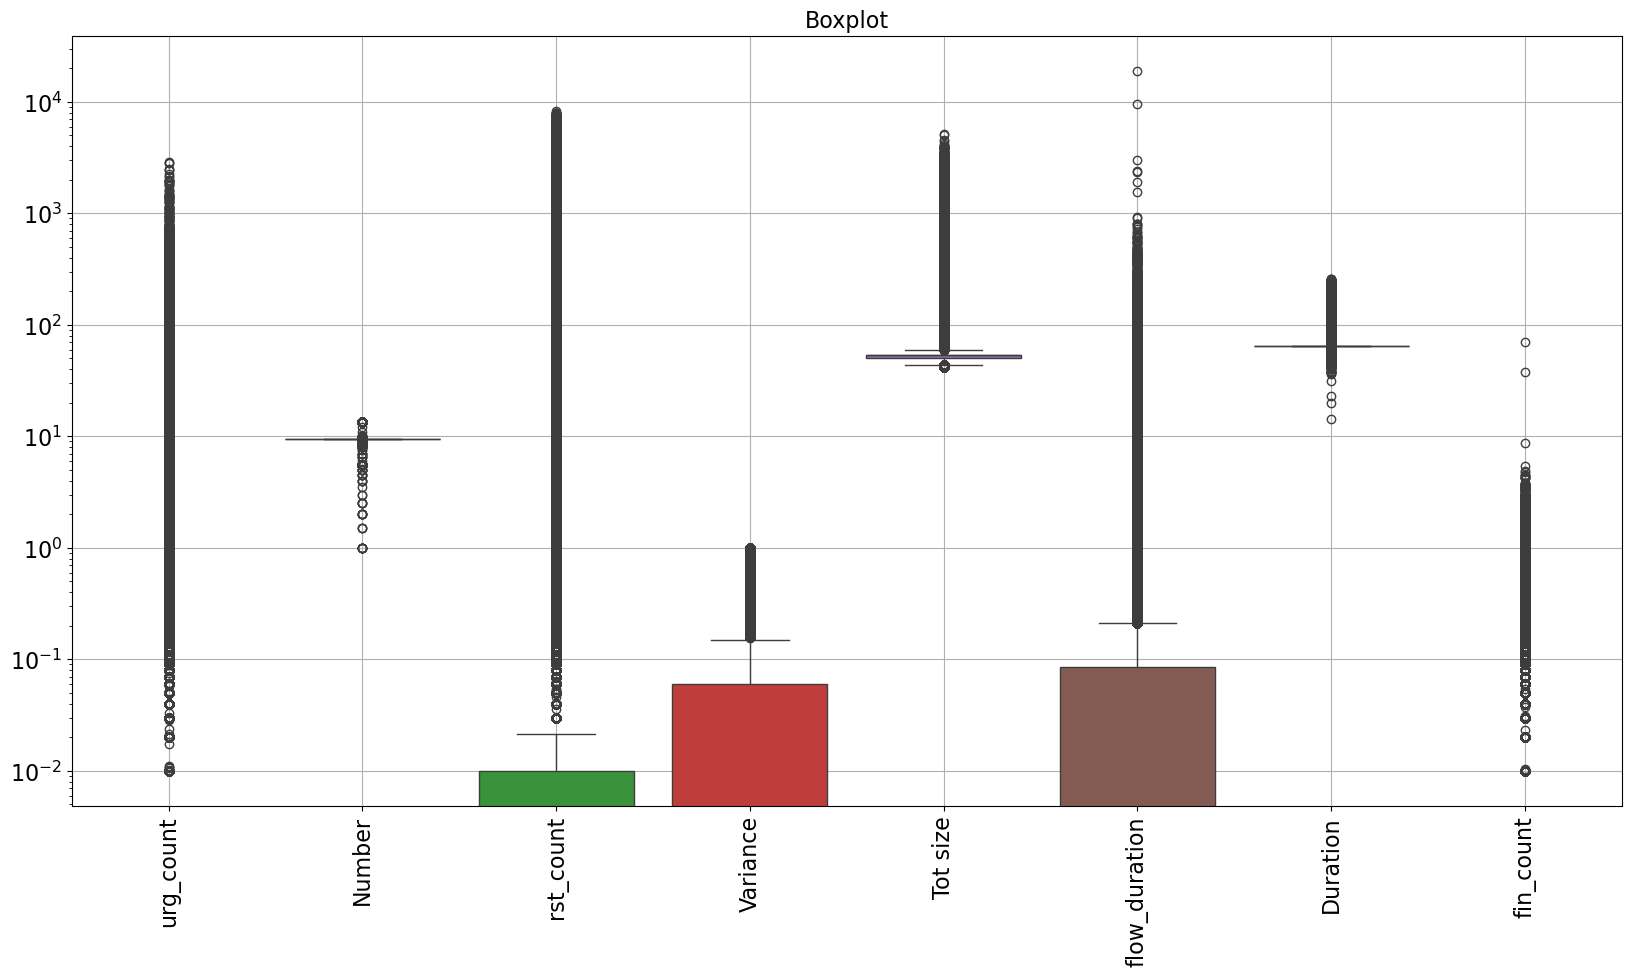

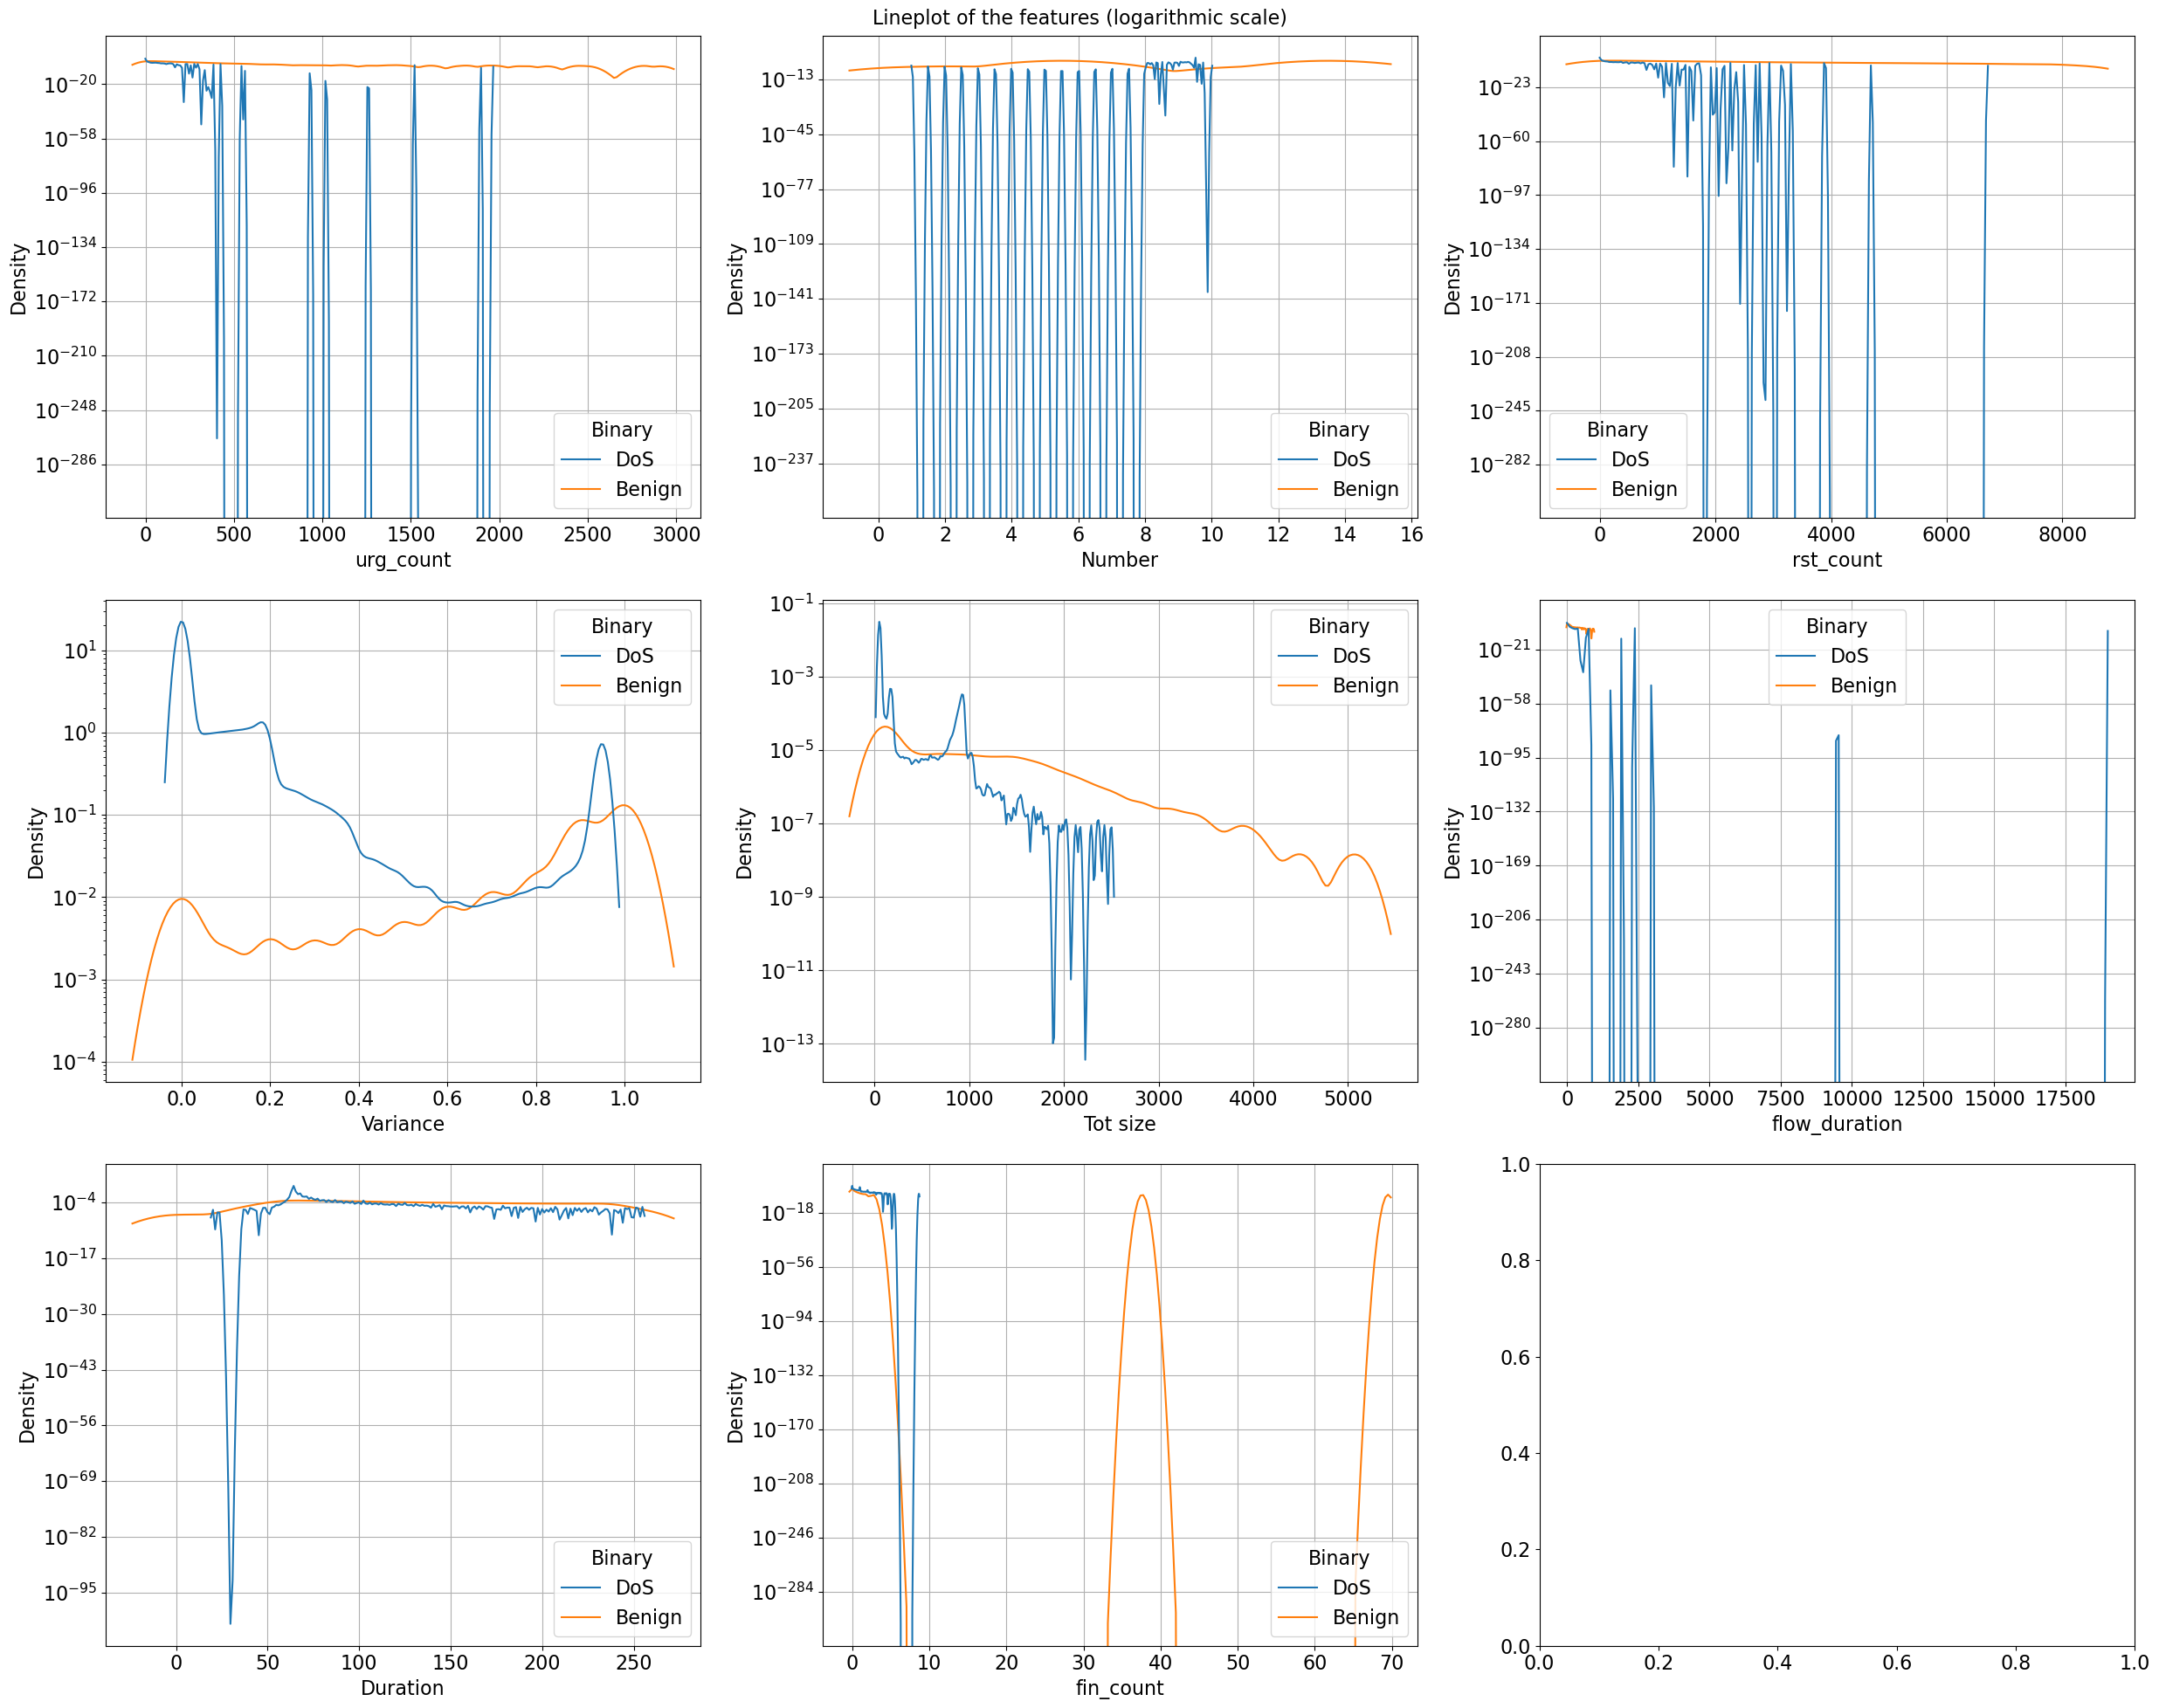

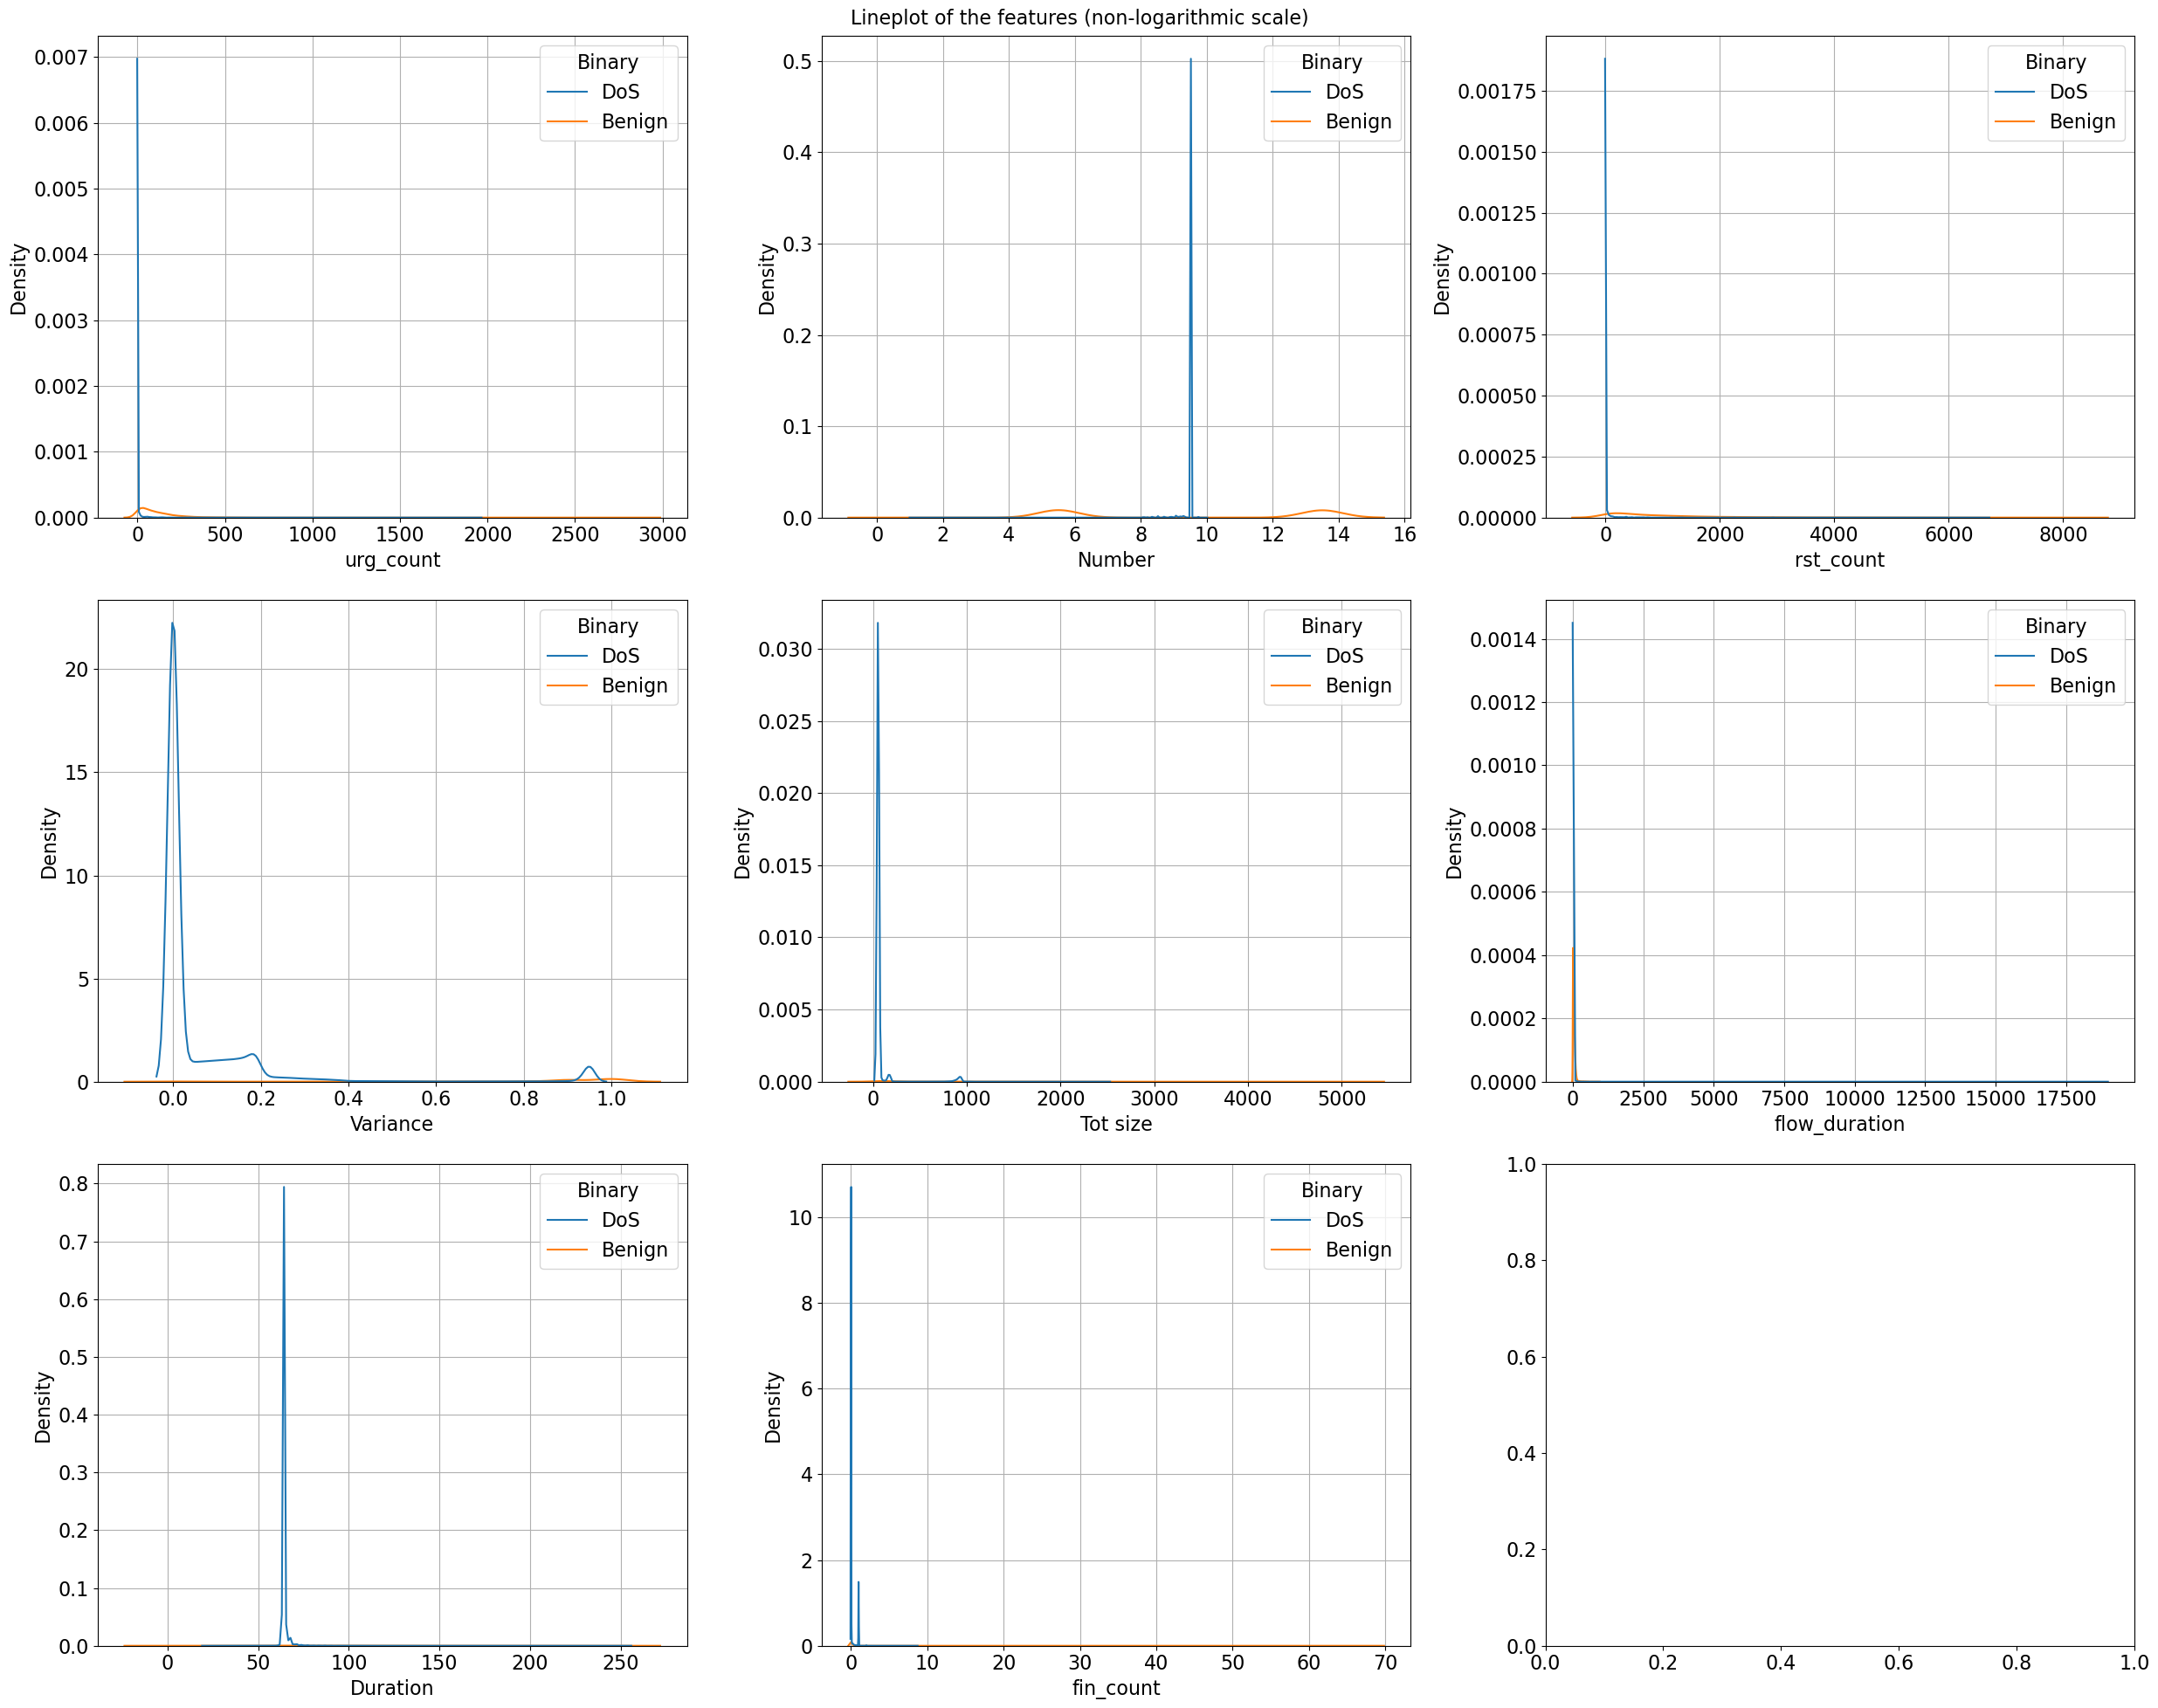

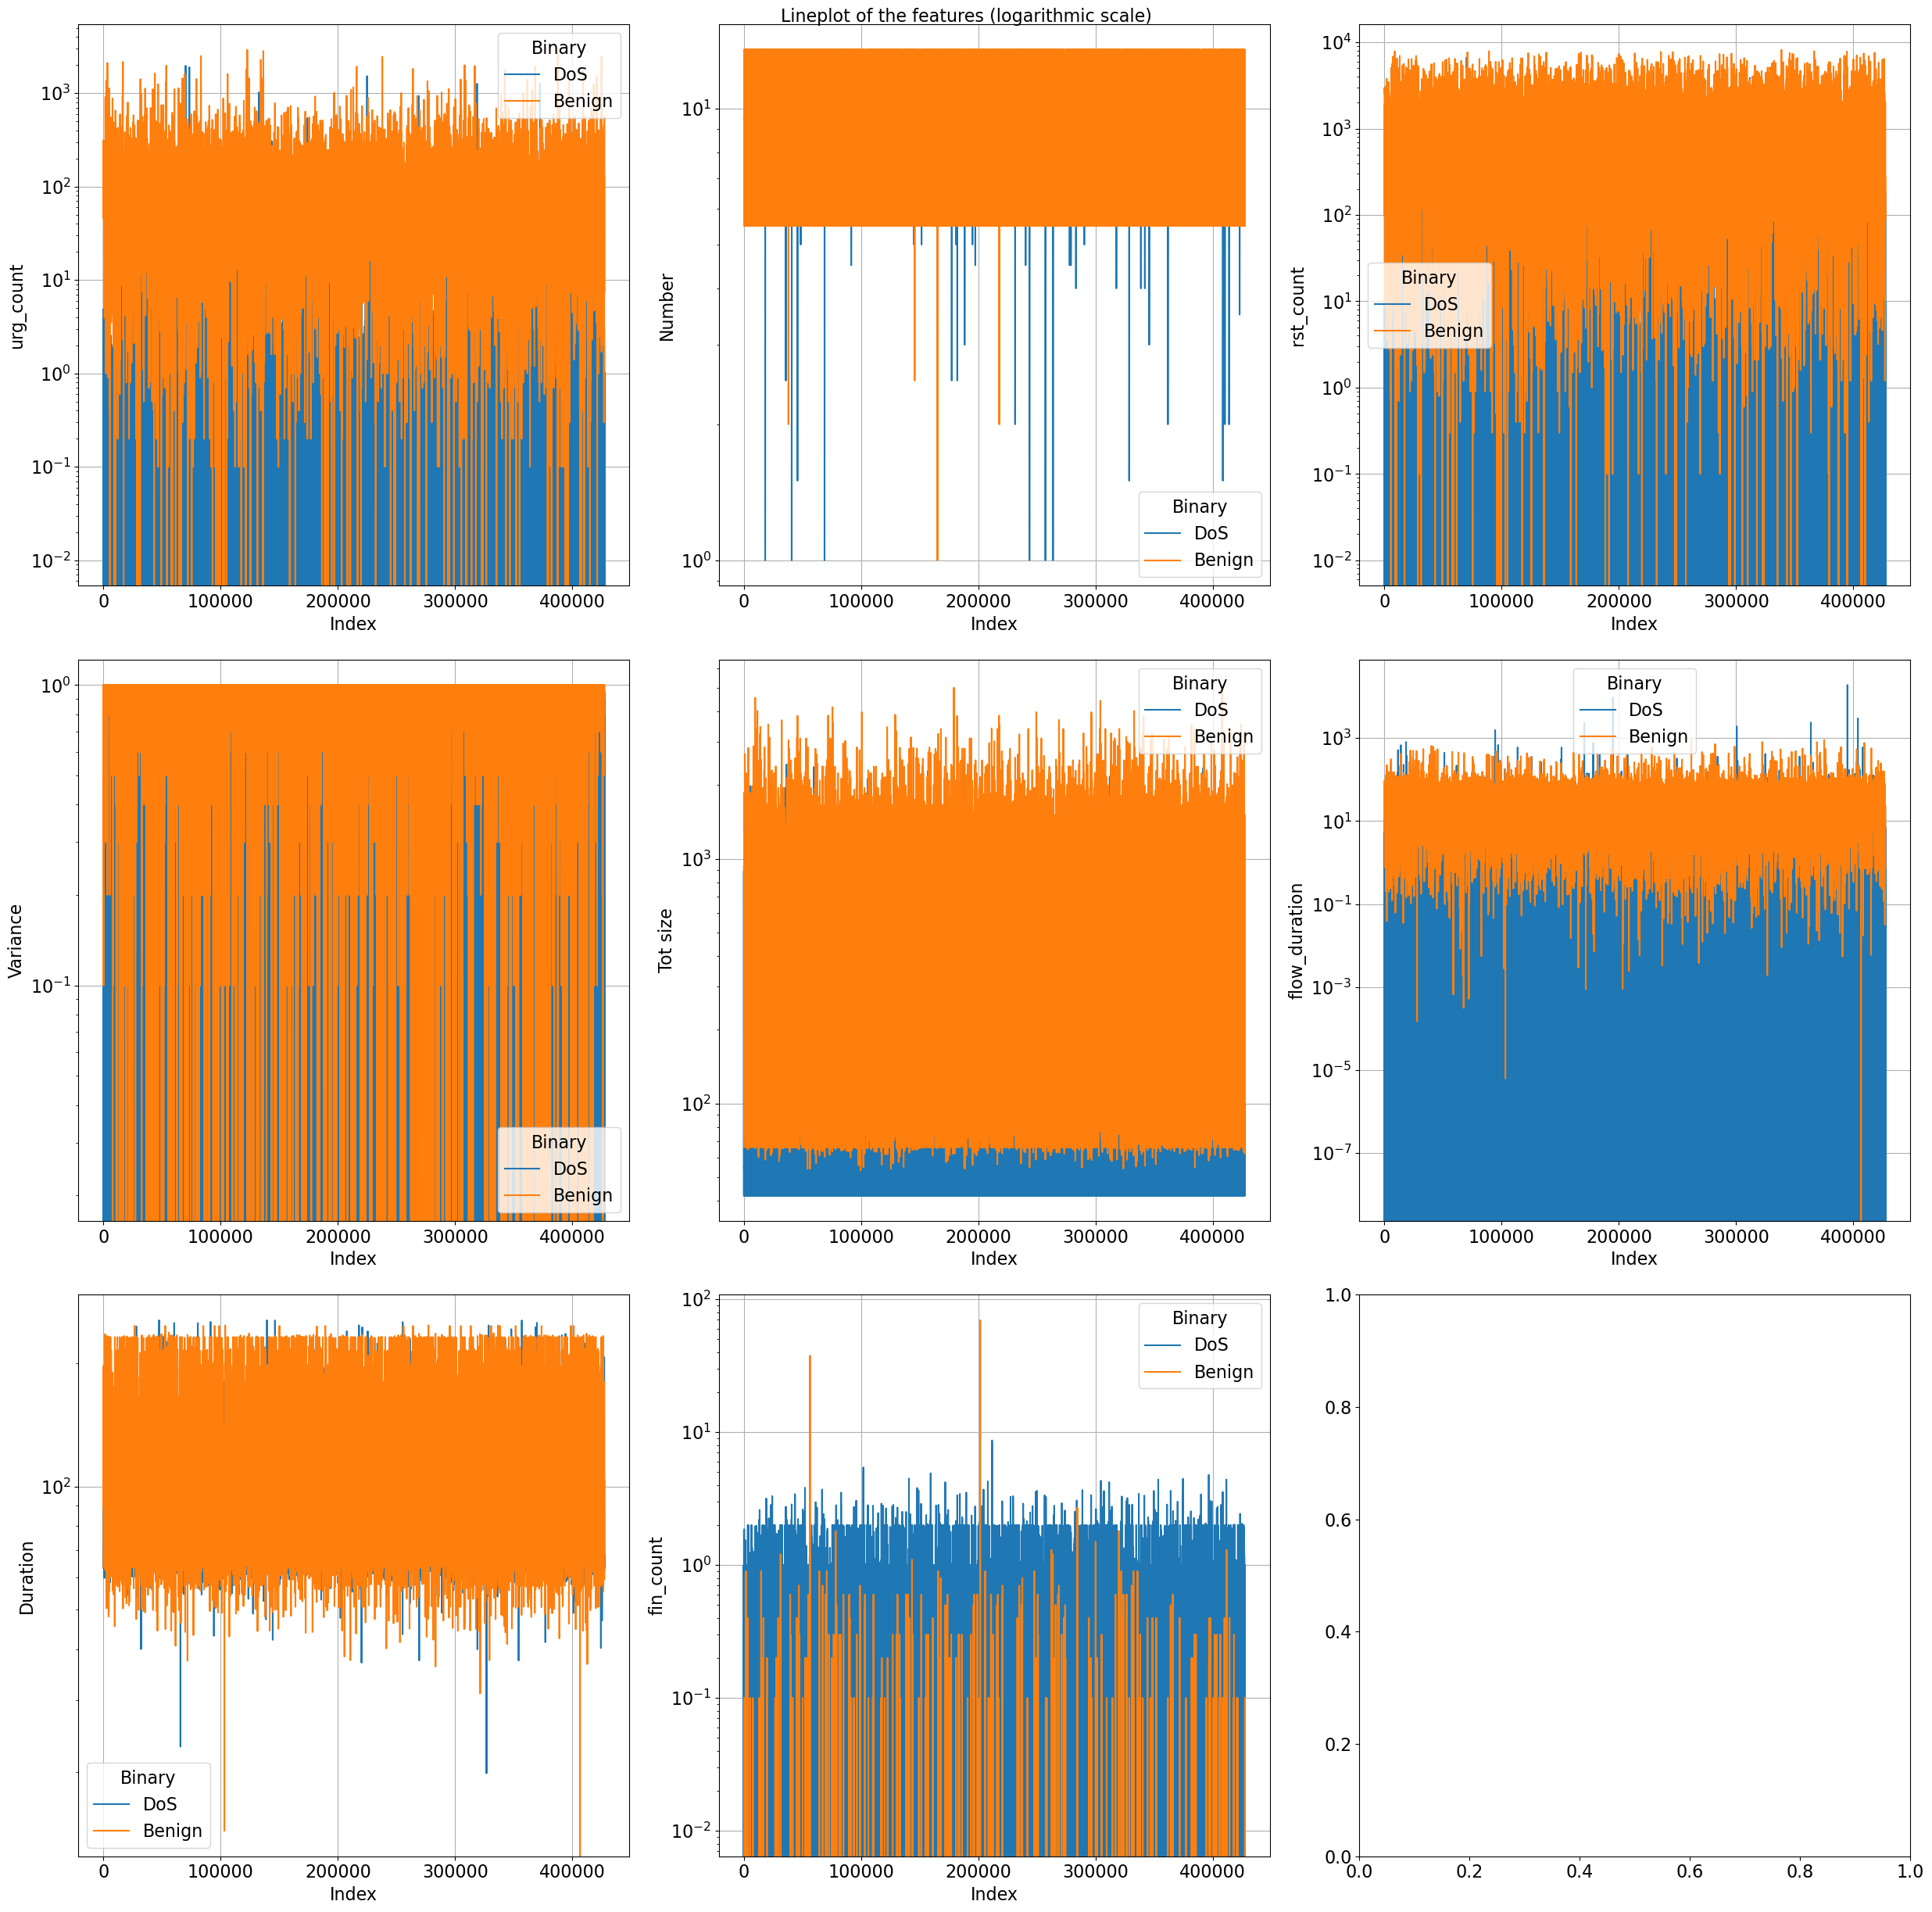

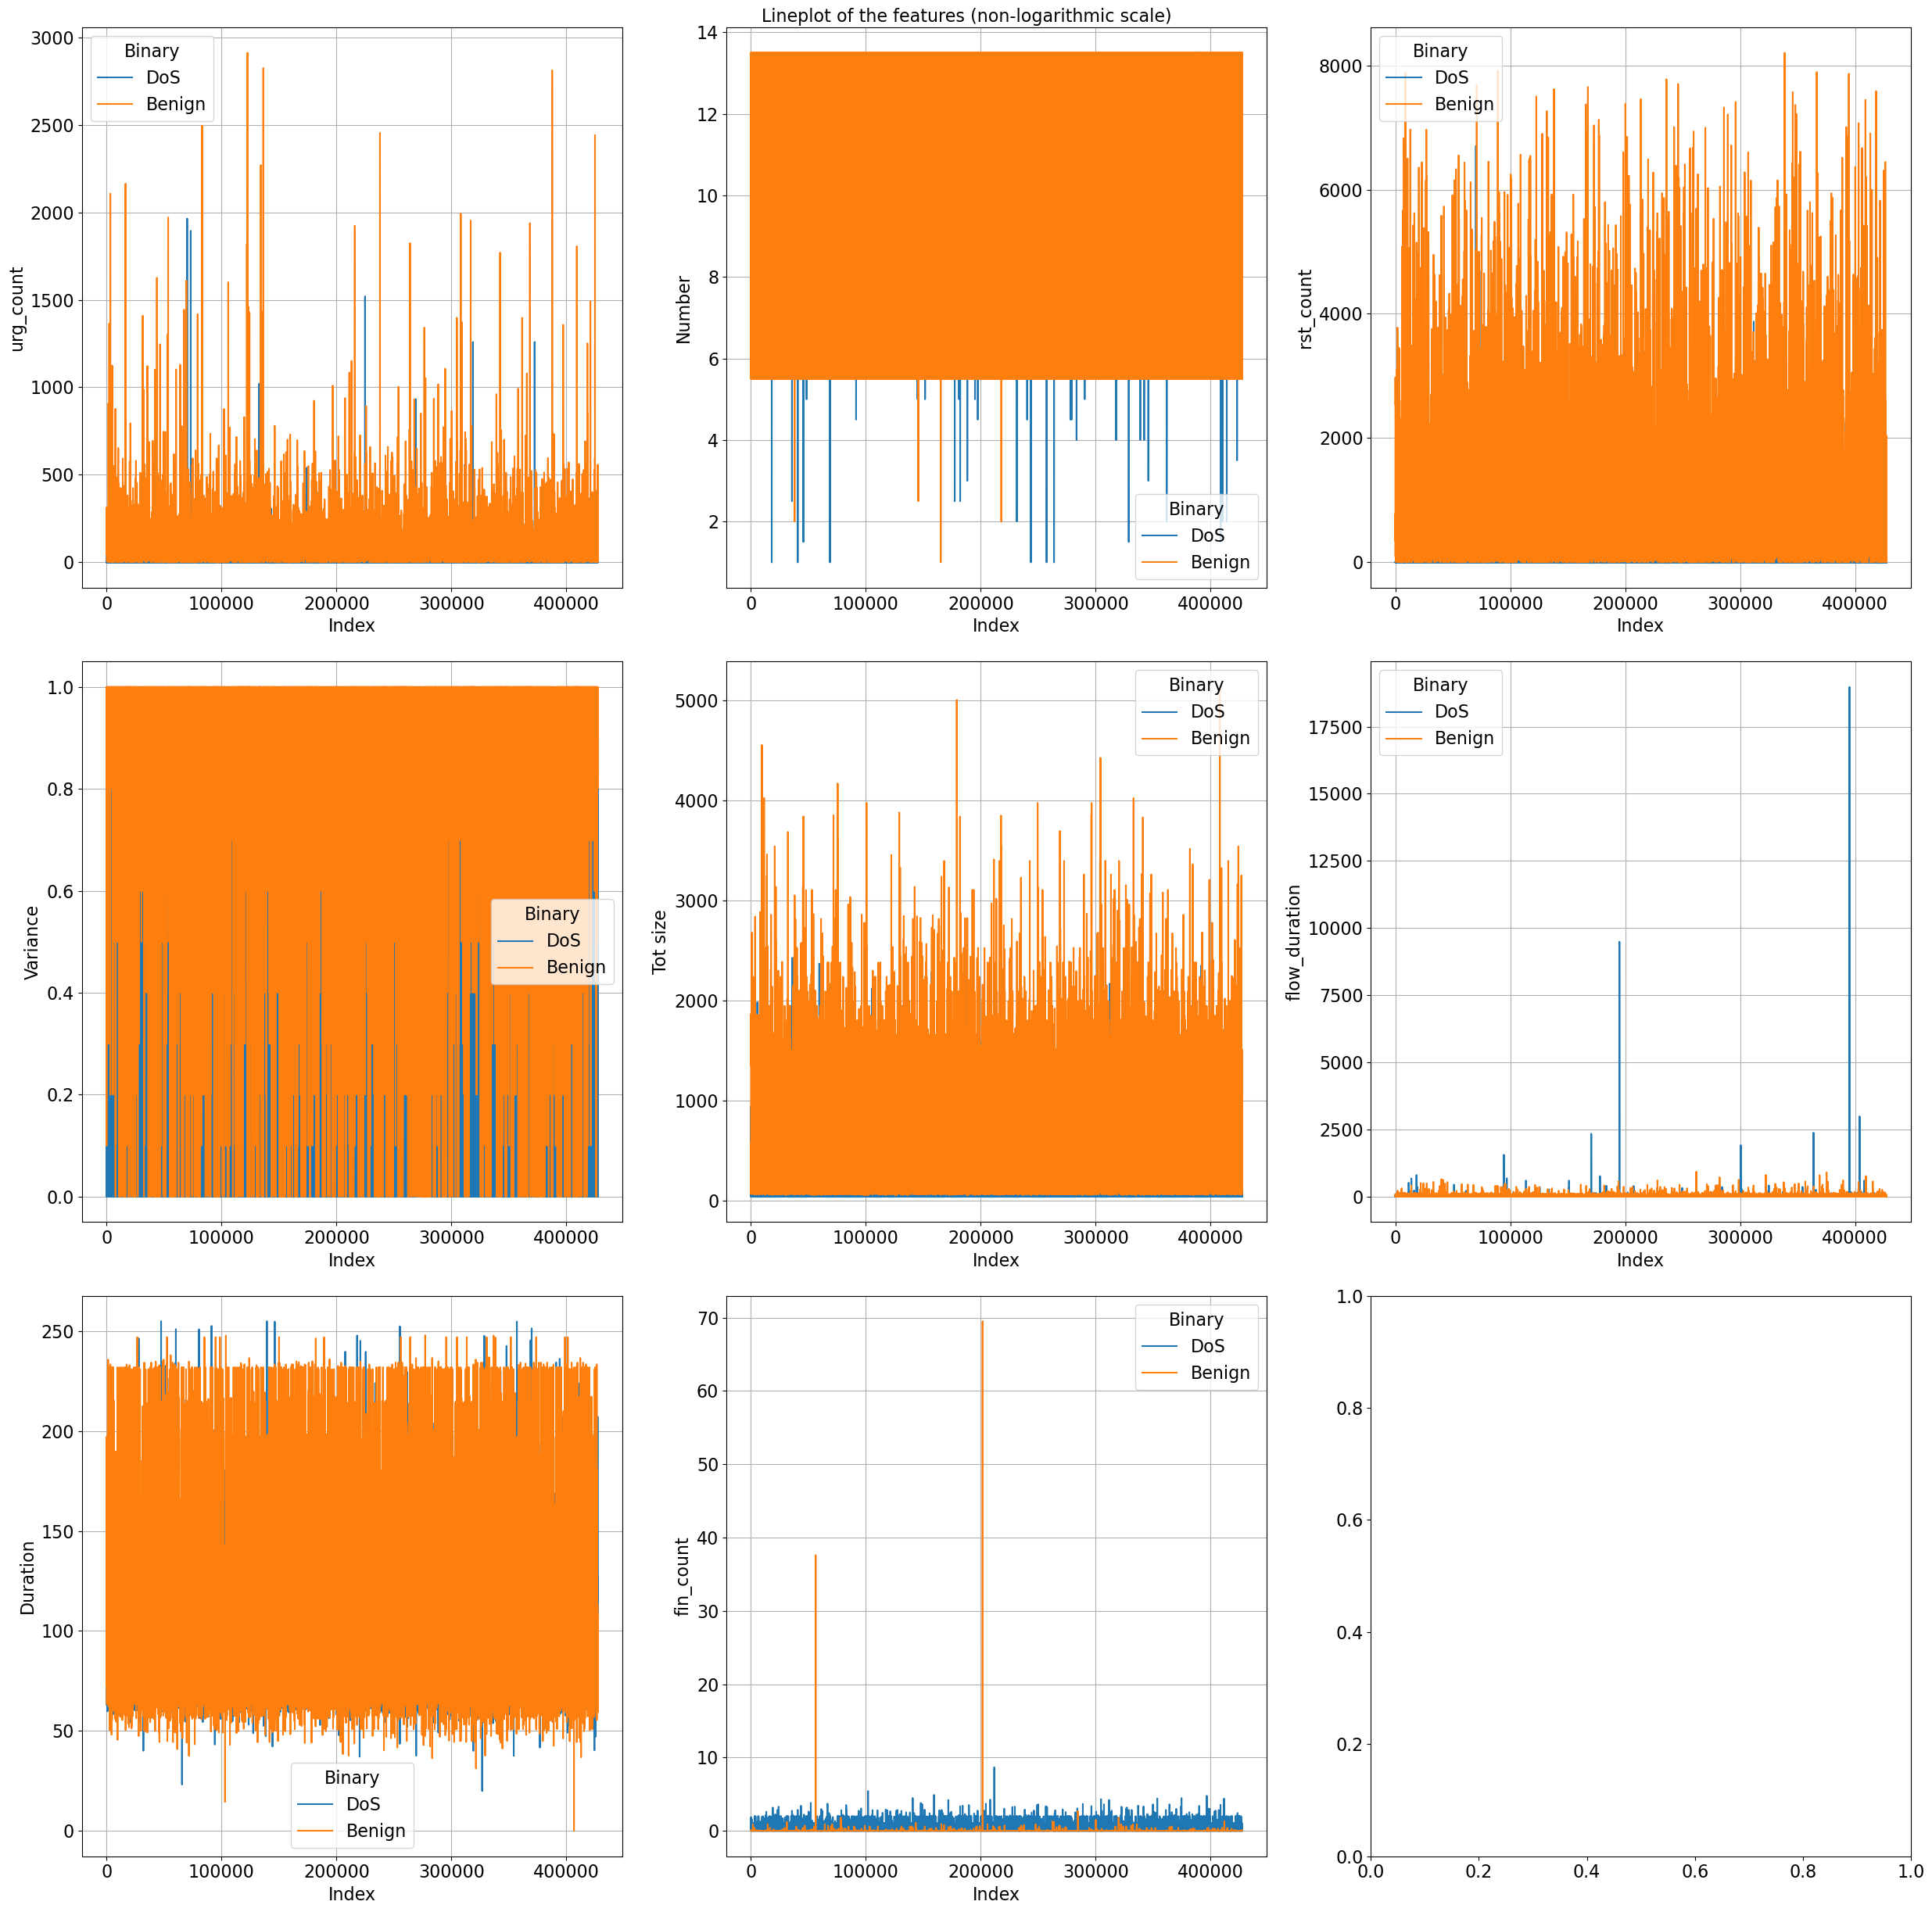

In [18]:
import matplotlib as mpl

# Setting the parameters as suggested in the error message
mpl.rcParams['agg.path.chunksize'] = 10000

# Load selected X columns
selected_X = pd.read_csv(model_path_binary+'selected_X_columns.csv').values

# Map selected X columns
selected_X = list(map(lambda x: x[0], selected_X))

plot_correlation_matrix(read_csv_file(train_sets[0], file_path)[selected_X], model_path_binary+'Correlation Matrix (sf).png', 'Correlation Matrix (sf)', lower=True)
# plot_correlation_matrix(read_csv_file(train_sets[0], file_path)[X_columns], model_path_binary+'Correlation Matrix (all features).png', 'Correlation Matrix (all features)', labels=False, lower=True)

if len(selected_X) > 10:
    new_selected_X = selected_X[:10]
else:
    new_selected_X = selected_X
    
pairplot_binary = new_selected_X.copy()
pairplot_binary.append('Binary')
plot_pairplot(read_csv_file(train_sets[0], file_path)[pairplot_binary].iloc[:1000], model_path_binary+'Pairplot.png', 'Binary', 'Pairplot')

plot_boxplot(read_csv_file(train_sets[0], file_path)[selected_X], model_path_binary+'Boxplot.png', 'Boxplot')

# print("Nb features:", len(selected_X))
plot_kde_plot(read_csv_file(train_sets[0], file_path), selected_X, model_path_binary+'KDE plot (logarithmic scale).png', 'Binary', figsize=(25, 20), yscaleLog=True)
plot_kde_plot(read_csv_file(train_sets[0], file_path), selected_X, model_path_binary+'KDE plot (non-logarithmic scale).png', 'Binary', figsize=(25, 20), yscaleLog=False)

plot_lineplot(read_csv_file(train_sets[0], file_path), selected_X, model_path_binary+'Lineplot (logarithmic scale).png', 'Binary', figsize=(25, 25), yscaleLog=True)
plot_lineplot(read_csv_file(train_sets[0], file_path), selected_X, model_path_binary+'Lineplot (non-logarithmic scale).png', 'Binary', figsize=(25, 25), yscaleLog=False)

## Display performance

In [20]:
# Preprocessing if necessary
performance = read_csv_file(performance_path, model_path_binary)
performance = performance.drop(3).reset_index(drop=True)
# performance.insert(0, 'Model', [d['Name'] for d in simpleModelsDef])

performance.head()
# performance.to_csv(model_path_binary + performance_path, index=False)

In [21]:
read_csv_file(performance_path, model_path_binary).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Model,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FU_rate,FL_rate,FU,FL,Total rows
11,SF_ET,1.000000,1.000000,1.000000,1.000000,0.999994,0.999992,0.999893,0.999943,2.706585e-07,0.000005,2,40,7389386
6,GBoost,1.000000,1.000000,0.999999,0.999999,0.999994,0.999976,0.999909,0.999943,1.082634e-06,0.000005,8,34,7389386
16,SF_Adaboost,1.000000,1.000000,1.000000,1.000000,0.999994,0.999956,0.999930,0.999943,2.165268e-06,0.000004,16,26,7389386
2,XGB,1.000000,1.000000,0.999999,1.000000,0.999994,0.999961,0.999914,0.999937,1.894609e-06,0.000004,14,32,7389386
1,RF,1.000000,1.000000,1.000000,1.000000,0.999994,0.999973,0.999898,0.999936,1.217963e-06,0.000005,9,38,7389386
4,Cat,1.000000,1.000000,1.000000,1.000000,0.999994,0.999963,0.999906,0.999934,1.759280e-06,0.000005,13,35,7389386
12,SF_XGB,1.000000,1.000000,0.999996,0.999998,0.999992,0.999929,0.999916,0.999922,3.518560e-06,0.000004,26,31,7389386
15,SF_GBoost,0.999999,0.999999,0.999980,0.999990,0.999992,0.999916,0.999926,0.999921,4.195206e-06,0.000004,31,27,7389386
7,Adaboost,1.000000,1.000000,1.000000,1.000000,0.999992,0.999931,0.999902,0.999917,3.383231e-06,0.000005,25,36,7389386
9,SF_DT,1.000000,1.000000,1.000000,1.000000,0.999991,0.999910,0.999915,0.999913,4.465865e-06,0.000004,33,31,7389386


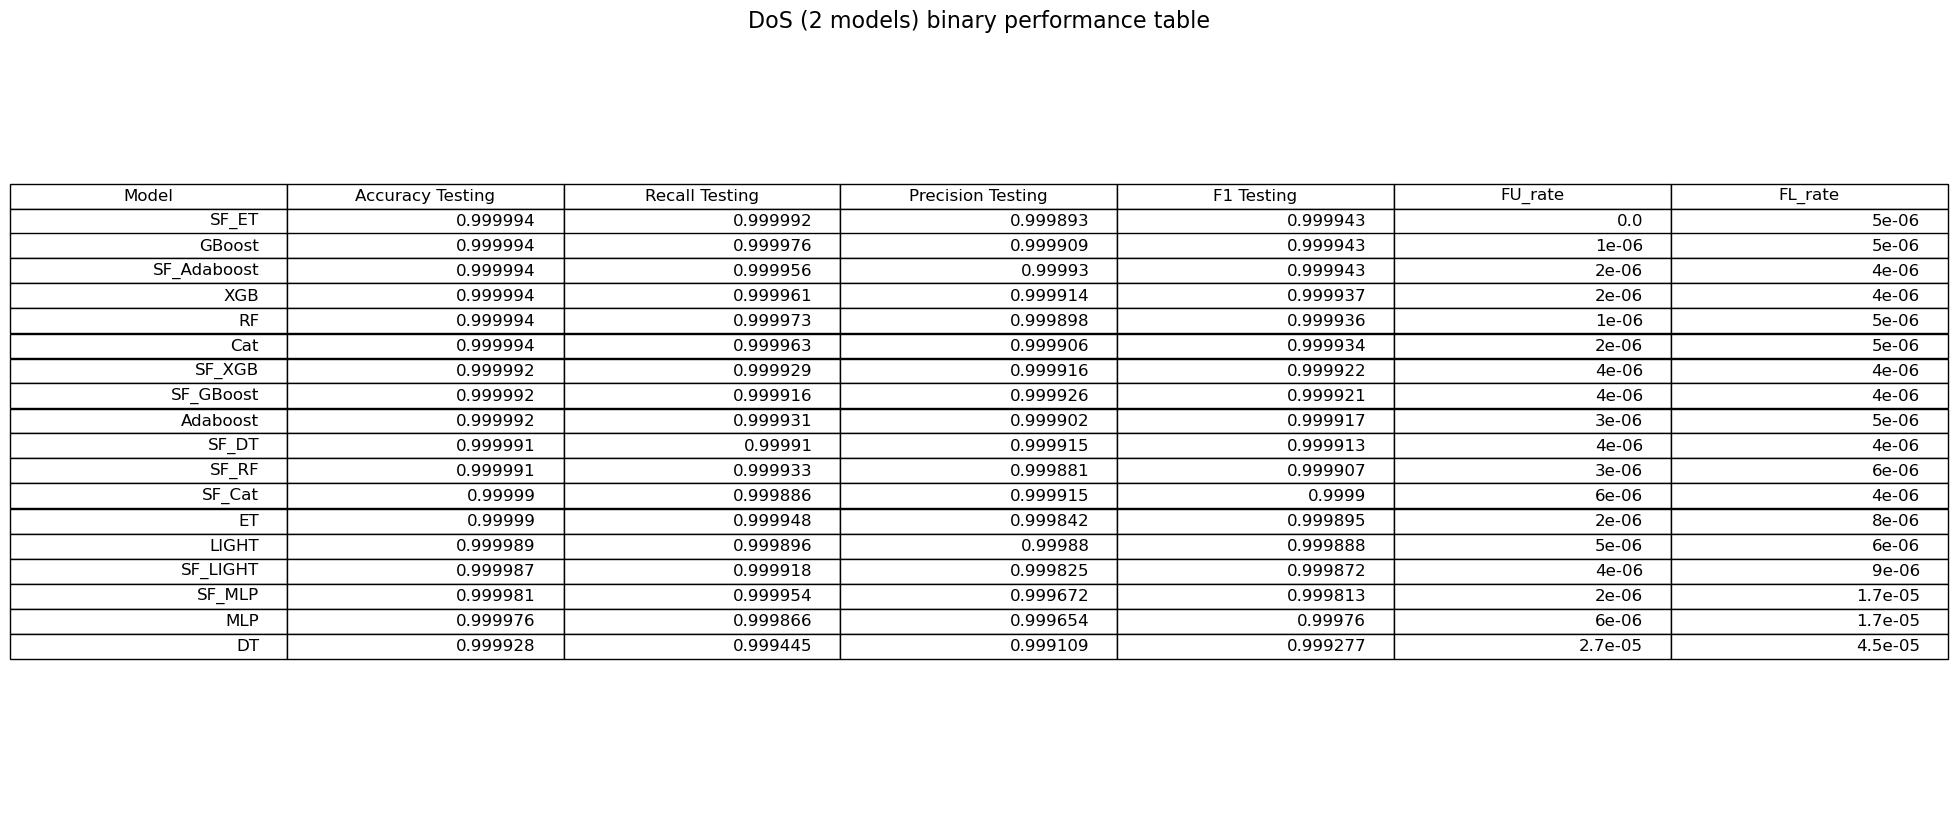

In [26]:
# Performance table
performance_table = read_csv_file(performance_path, model_path_binary).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(30)
performance_table = performance_table[['Model', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FU_rate', 'FL_rate']]
performance_table = performance_table.round(6)

plot_performance_table(performance_table, model_path_binary+'Performance table.png', 'DoS (2 models) binary performance table')

## Do prediction for after build sets

In [5]:
# Define model
model_path = '.\\DoS_model\\Binary\\'
model = joblib.load(model_path + 'model_XGB.joblib')

try:
    # scaler = joblib.load(model_path+'scaler.joblib')
    encoder = joblib.load(model_path+'encoder.joblib')
except:
    raise Exception("Please, build models first")

# Get prediction
X_test, y_test, y_pred, z_test = get_prediction_by_model(model, after_build_sets, file_path, X_columns, y_column=z_column, z_column=y_column, scale=True, encode=True, scaler=scaler, encoder=encoder)

# Build new dataframe and save it
new_after_build_set_scaled = pd.DataFrame(X_test, columns=X_columns)
new_after_build_set_scaled[z_column] = encoder.inverse_transform(y_test)
new_after_build_set_scaled['Prediction'] = encoder.inverse_transform(y_pred)
# new_after_build_set_scaled['Trinary'] = trinary_col.values
new_after_build_set_scaled[y_column] = z_test
count = len(new_after_build_set_scaled[new_after_build_set_scaled[z_column] != new_after_build_set_scaled['Prediction']])

new_after_build_set_scaled.to_csv('.\\DoS_model\\after_build_set_scaled.csv', index=False)

# Get performance
res = pd.DataFrame([[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='weighted'), precision_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted'), count, count / len(new_after_build_set_scaled) * 100,len(new_after_build_set_scaled)]], columns=['Accuracy', 'Recall', 'Precision', 'F1', 'Mispredicted count', 'Mispredicted rate', 'Total rows'])

del new_after_build_set_scaled

res.head()

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:30<00:00,  1.62s/it]


,Accuracy,Recall,Precision,F1,Mispredicted count,Mispredicted rate,Total rows
0,0.999992,0.999992,0.999992,0.999992,67,0.00077,8703485


# Second model (All DoS classes)

## Building models

In [9]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
    {
        "Name": "RF",
        "Model": RandomForestClassifier(random_state = 42)
    },
    {
        "Name": "ET",
        "Model": ExtraTreesClassifier(random_state = 42)
    },
    {
        "Name": "XGB",
        "Model": XGBClassifier(random_state = 42)
    },
    # {
    #     "Name": "Cat",
    #     "Model": CatBoostClassifier(random_state = 42, verbose = 0)
    # },
    {
        "Name": "LIGHT",
        "Model": LGBMClassifier(random_state = 42, verbose = 0)
    },
    # {
    #     "Name": "GBoost",
    #     "Model": GradientBoostingClassifier(random_state = 42)
    # },
    {
        "Name": "Adaboost",
        "Model": AdaBoostClassifier(random_state = 42)
    },
    # {
    #     "Name": "MLP",
    #     "Model": MLPClassifier(hidden_layer_sizes = (100,20), max_iter = 300, activation = 'relu', solver = 'adam', random_state = 42)
    # },
]

In [14]:
filter_name = [
    {'name': 'DoS', 'type': '='}
]
filter_cols = ['Binary']

In [ ]:
# Import or define encoder and performance dataframe
encoder = get_or_define_encoder(model_path_all_classes)
performance = get_or_define_performance_df(model_path_all_classes, performance_path)

# Buidling models
for model in simpleModelsDef:
    # Build model
    performance, encoder = build_model_multifiltered(model['Model'], model['Name'], train_sets, test_sets, file_path, performance, model_path_all_classes, X_columns=X_columns , y_column=y_column, filter_cols=filter_cols, filter_bool=True, filter_name=filter_name, encoder=encoder, scaler=scaler, confusionMatrix=False)

    # Save performance
    performance.to_csv(model_path_all_classes + performance_path, index=False)

joblib.dump(encoder, model_path_all_classes+'encoder.joblib')

In [9]:
encoder = joblib.load(model_path_all_classes+'encoder.joblib')
num_classes = encoder.classes_
print("Nombre de classes :", len(num_classes), num_classes)

Nombre de classes : 16 ['DDoS-ACK_Fragmentation' 'DDoS-HTTP_Flood' 'DDoS-ICMP_Flood'
 'DDoS-ICMP_Fragmentation' 'DDoS-PSHACK_Flood' 'DDoS-RSTFINFlood'
 'DDoS-SYN_Flood' 'DDoS-SlowLoris' 'DDoS-SynonymousIP_Flood'
 'DDoS-TCP_Flood' 'DDoS-UDP_Flood' 'DDoS-UDP_Fragmentation'
 'DoS-HTTP_Flood' 'DoS-SYN_Flood' 'DoS-TCP_Flood' 'DoS-UDP_Flood']


#### Featues importance

[19:12:43] WARNING: D:\bld\xgboost-split_1679035243975\work\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



100%|██████████| 6/6 [00:00<00:00, 54.85it/s]


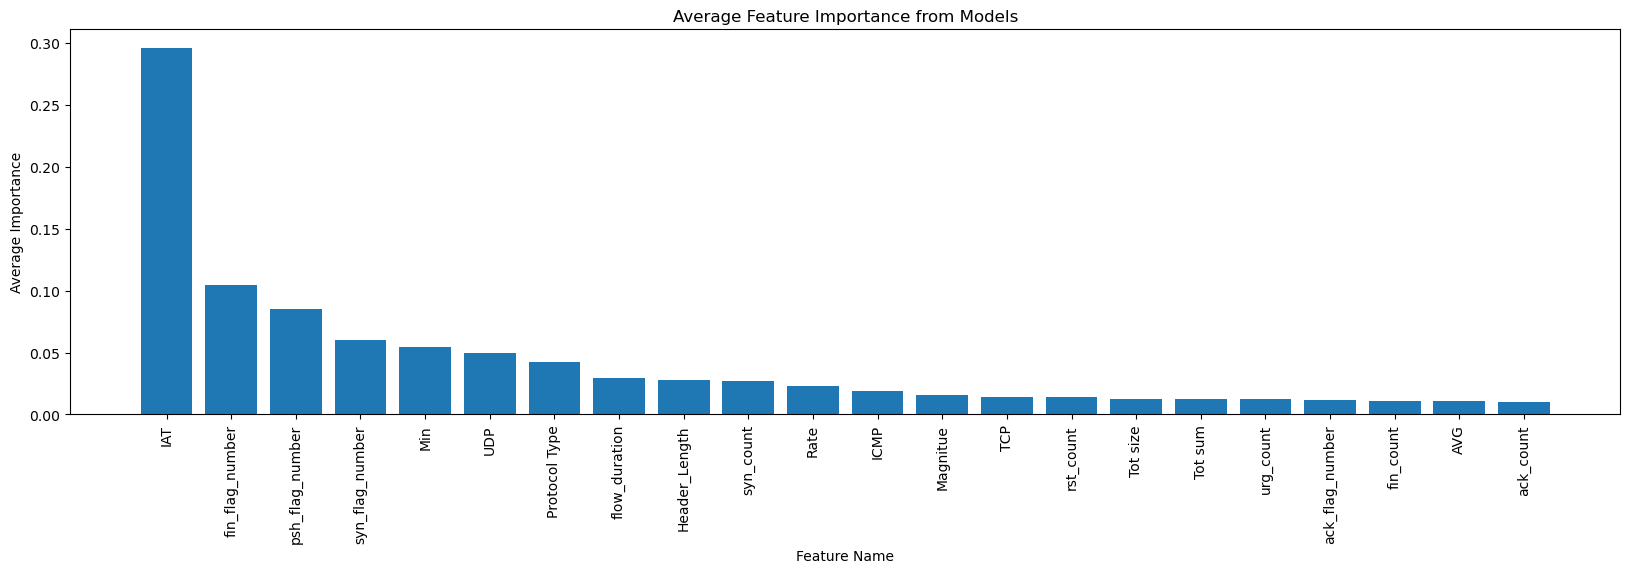

,Feature,Average Importance
39,IAT,0.295915
7,fin_flag_number,0.104200
10,psh_flag_number,0.084993
8,syn_flag_number,0.060136
34,Min,0.054523
27,UDP,0.049903
2,Protocol Type,0.042595
0,flow_duration,0.029576
1,Header_Length,0.027758
15,syn_count,0.027209


In [10]:
# Import encoder and get all features
encoder = get_encoder(model_path_all_classes, "Please, build models first")

simpleModelsDef = model_dict_refactor_with_load_model(simpleModelsDef, model_path_all_classes)

# Get feature importance
average_importance_df = calculate_and_plot_feature_importance(simpleModelsDef, train_sets, X_columns, z_column, X_columns, file_path, fitted_models=True, filter_bool=False, scaler=scaler, encoder=encoder)
average_importance_df.to_csv('.\\resultats\\DoS_2_models\\All_classes\\feature_importance.csv', index=False)
average_importance_df.head(average_importance_df.size)

## Display performance

In [11]:
# Preprocessing if necessary
performance = read_csv_file(performance_path, model_path_all_classes)
performance = performance.drop(0).reset_index(drop=True)
# performance.insert(0, 'Model', [d['Name'] for d in simpleModelsDef])

performance.head()
performance.to_csv(model_path_all_classes + performance_path, index=False)

In [7]:
read_csv_file(performance_path, model_path_all_classes).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Model,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FU_rate,FL_rate,FU,FL,Total rows
5,DT,1.000000,1.000000,1.000000,1.000000,0.999661,0.995846,0.995685,0.995765,0.000166,0.000173,1195,1243,7201481
2,XGB,0.999902,0.999912,0.999936,0.999924,0.999584,0.994265,0.992981,0.993537,0.000140,0.000275,1010,1984,7201481
0,RF,0.999983,0.999978,0.999989,0.999984,0.999131,0.992292,0.988353,0.990114,0.000458,0.000411,3300,2959,7201481
1,ET,1.000000,1.000000,1.000000,1.000000,0.997346,0.980229,0.972252,0.975277,0.001349,0.001305,9717,9396,7201481
3,LIGHT,0.529868,0.341591,0.380370,0.352775,0.913611,0.652267,0.671212,0.647037,0.046696,0.039693,336283,285848,7201481
4,Adaboost,0.791984,0.645122,0.630099,0.625202,0.802192,0.713009,0.702917,0.656976,0.114526,0.083283,824754,599759,7201481


## Final prediction

## Tests

In [42]:
import gc
gc.collect()

406